In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import re
import string
import pickle 
from scipy.stats import skew
from collections import defaultdict
from tqdm import tqdm_notebook
from pandas_summary import DataFrameSummary
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc as sk_auc, roc_curve, precision_score, recall_score
from keras.metrics import categorical_accuracy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate, Flatten, Reshape, Concatenate, Lambda
from keras.backend import repeat_elements

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 30
pd.options.display.max_rows = 5000
seed = 42
np.random.seed(seed)

Using TensorFlow backend.
W0928 01:30:25.886172  9980 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


# Constants

In [2]:
data_path = '../data/'
DROP_DUPLICATES = True
TFIDF = True
CREATE_EMB_INDEX = True
CREATE_EMB_MATRIX = True
PRETRAINED_EMBEDDINGS = True
SCENARIO1 = False
SCENARIO2 = False
SCENARIO3 = True
BUSINESS_CODE = True
BUSINESS_LEVEL = 3
SAMPLE_WEIGHTS = True
MIN_SAMPLE_WEIGHT = 0.01
CATALOG_MIN_ENTRIES = 200
MIN_VALTEST_FRAC = 0.20
MAX_VALTEST_FRAC = 0.23

SAVE_TOKENIZER = True
SAVE_BUSINESS_INDEX = True
SAVE_TEST_SET = True

if SCENARIO1 + SCENARIO2 + SCENARIO3 != 1:
    raise Exception('Exactly 1 scenario should be selected')

# Load in data from pickle

The version of the pre-processed data is determined by which scenario is active and whether or not we consider business codes

In [3]:
BUSINESS_ADDITION = ''
if BUSINESS_CODE:
    BUSINESS_ADDITION = '_business'
if SCENARIO1:
    df = pd.read_pickle(data_path + '2017-2018' + BUSINESS_ADDITION + '.pkl')
    df.shape
else:
    if SCENARIO2:
        version = '_scen2'
    else:
        version = '_scen3'
    df = pd.read_pickle(data_path + 'catalog201810' + version + BUSINESS_ADDITION + '.pkl')
    df.shape

# Split into train and test set. The active scenario decides how the data is split

In [4]:
df['Label'] = df['Label'].astype('str')
y = df['Label']

In [5]:
df.shape

(865161, 4)

## The data is split randomly for scenario 1 and 3

In [6]:
if SCENARIO1 or SCENARIO3:
    if BUSINESS_CODE:
        X_train, X_vt, y_train, y_vt = train_test_split(df.loc[:, ['ProductName', 'Full_code']], y, test_size=MIN_VALTEST_FRAC)
    else:
        X_train, X_vt, y_train, y_vt = train_test_split(df['ProductName'], y, test_size=MIN_VALTEST_FRAC)
    X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, test_size=0.5)

## For scenario 2 we split the data by keeping each catalog intact and distributing the full catalogs to different sets

The catalogs that are to be used in validation and testing have to be of a certain size in order to get representable evalutation of the performace accross catalogs. 

Extra effort is put into keeping the absolute size of the different datasets within predefined acceptable ranges. Especially the test set has been given a strict mininum size

In [7]:
if SCENARIO2:
    # only consider data from catalogs of a certain size for the test set
    catalogs = df['CatalogueID'].value_counts().to_dict()
    catalogs_test_potentials = {}
    for k, v in catalogs.items():
        if v >= CATALOG_MIN_ENTRIES:
            catalogs_test_potentials[k] = v
    
    # ensure that the extracted catalogs for the test set is neither too large or too small
    min_valtest_size = df.shape[0]*MIN_VALTEST_FRAC
    max_valtest_size = df.shape[0]*MAX_VALTEST_FRAC
    min_test_size = df.shape[0]*(MIN_VALTEST_FRAC/2)
    max_test_size = df.shape[0]*(MAX_VALTEST_FRAC/2)
    mean_potential_cat_sz = np.mean(list(catalogs_test_potentials.values()))
    n_test_cats = int(min_valtest_size/mean_potential_cat_sz)
    valtest_set_found = False
    while not valtest_set_found:
        selection = np.random.choice(list(catalogs_test_potentials.keys()), size=n_test_cats, replace=False)
        size = 0
        # find size of selected catalogs
        for k in selection:
            size += catalogs_test_potentials[k]
        # check if selected catalogs have an acceptable total size
        if size >= min_valtest_size and size <= max_valtest_size:
            subsplit_found = False
            # after finding a split into training and valtest, split valtest into validation and test
            while not subsplit_found:
                test_selection = np.random.choice(selection, size=n_test_cats//2, replace=False)
                subsize = 0
                for g in test_selection:
                    subsize += catalogs_test_potentials[g]
                if subsize >= min_test_size and subsize <= max_test_size:
                    subsplit_found = True
                    test_selection = set(test_selection)
                print("Subsplit status: {}".format('Found' if subsplit_found else 'Not found'))
            valtest_set_found = True
            selection = set(selection)
        print('Split status: {}'.format('Found' if valtest_set_found else 'Not found'))
    
    # split the data according to which set the catalog has been distributed to
    train_mask = ~(df['CatalogueID'].isin(selection))
    test_mask = (df['CatalogueID'].isin(test_selection))
    val_selection = selection-test_selection
    val_mask = (df['CatalogueID'].isin(val_selection))
    df_train = df.loc[train_mask]
    df_val = df.loc[val_mask]
    df_test = df.loc[test_mask]
    if BUSINESS_CODE:
        X_train = df_train.loc[:, ['ProductName', 'Full_code', 'CatalogueID']]
        X_val = df_val.loc[:, ['ProductName', 'Full_code', 'CatalogueID']]
        X_test = df_test.loc[:, ['ProductName', 'Full_code', 'CatalogueID']]
    else:
        X_train = df_train.loc[:, ['ProductName']]
        X_val = df_val.loc[:, ['ProductName']]
        X_test = df_test.loc[:, ['ProductName']]
    y_train = df_train['Label']
    y_val = df_val['Label']
    y_test = df_test['Label']

In [8]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((692128, 2), (692128,), (86516, 2), (86516,), (86517, 2), (86517,))

# Identify descriptions with multiple correct answers

Some descriptions appear with more than one unique UNSPSC code in the data. For instance if the description is "Scissor" if might be given a code for desktop supplies or medical equipment. To handle this we keep a set of used codes for each unique description, and consider any of these correct for said description. The intuition is that this set could be presented to the user when inputting previously seen descriptions, allowing the user to select the most fitting UNSPSC code from the set.

In [9]:
%%time
product_label_map = defaultdict(lambda: set([]))
for product_name, label in df.loc[:, ['ProductName', 'Label']].values:
    product_label_map[product_name].add(label)

Wall time: 1.74 s


In [10]:
product_label_map

defaultdict(<function __main__.<lambda>()>,
            {'HYLLE TIL TRANSPORTCONTAINER': {'101316'},
             'TRANSPORTCONTAINER COMPACTAIN': {'101316'},
             'TRANSPORTCONTAINER FOLDIA': {'101316'},
             'TRANSPORTCONTAINER SMART CUBE': {'101316'},
             'Plastakvarium/Terrarium': {'101317'},
             'TAHIN 12 GL': {'101516'},
             'FRØ ARNØY SPESIALBLANDING 1KG': {'101517'},
             'SAFRAN PK 1 GRAM': {'101518'},
             'GRØNNSAKSMIX JULIENNE 1 KG GULROT / HODEKÅL': {'101524',
              '501015',
              '504026'},
             'RATATOUILLE': {'101524'},
             'REDDIK JULIENNE 1 KG': {'101524'},
             'REDDIKER BT': {'101524'},
             'RETTICH': {'101524'},
             'RETTICH STAVER': {'101524'},
             'SPIRER REDIKKSPIRER': {'101524', '504026'},
             'KRUS BUNT': {'101618'},
             'MOSEFJERNER TAK GTI 1L RENGJØRING AV TAK OG BETONGHELLER': {'101717'},
             'UGRESSMID P

# Delete large objects

In [11]:
del df
if SCENARIO2:
    del df_train
    del df_val
    del df_test

In [12]:
import gc
gc.collect()

67

# Load pretrained word embeddings and create embedding matrix

Downloaded from http://vectors.nlpl.eu/repository/11/77.zip


In [13]:
maxlen = max(len(x) for x in X_train['ProductName'])  # max number of words in a description to use
maxlen

160

In [14]:
embed_size = 100 # how big is each word vector
max_features = 500000 # how many unique words to use (i.e num rows in embedding vector)

In [15]:
tokenizer = Tokenizer(num_words=max_features)
if BUSINESS_CODE:
    tokenizer.fit_on_texts(X_train['ProductName'].tolist())
    X_train_tokens = pad_sequences(tokenizer.texts_to_sequences(X_train['ProductName'].tolist()), maxlen=maxlen)
    X_val_tokens = pad_sequences(tokenizer.texts_to_sequences(X_val['ProductName'].tolist()), maxlen=maxlen)
    X_test_tokens = pad_sequences(tokenizer.texts_to_sequences(X_test['ProductName'].tolist()), maxlen=maxlen)
else:
    tokenizer.fit_on_texts(X_train.tolist())
    X_train_tokens = pad_sequences(tokenizer.texts_to_sequences(X_train.tolist()), maxlen=maxlen)
    X_val_tokens = pad_sequences(tokenizer.texts_to_sequences(X_val.tolist()), maxlen=maxlen)
    X_test_tokens = pad_sequences(tokenizer.texts_to_sequences(X_test.tolist()), maxlen=maxlen)

In [16]:
len(tokenizer.word_index)

290040

## In order to be able to transform new text descriptions to the format the trained model expects, we have to save the tokenizer that was fitted on the training data.

In [17]:
if SAVE_TOKENIZER:
    with open('tokenizer.pkl', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Create embedding index from pretrained word_embeddings

In [18]:
embedding_addition = ''
if SCENARIO2:
    embedding_addition = '_scen2'
elif SCENARIO3:
    embedding_addition = '_scen3'

In [19]:
if CREATE_EMB_INDEX:
    embeddings_index = {}
    with open(data_path + "model.txt", "r", encoding="latin1") as f:
        while True:
            line = f.readline().split()
            if not line:
                break
            word = line[0]
            arr = line[1:]
            if len(arr)==100:
                embeddings_index[word] = np.asarray(arr, dtype='float32')
    pickle.dump(embeddings_index, open(data_path + "embeddings_index" + embedding_addition + ".pkl", "wb"))
    

## Create embedding matrix by looking at the most popular words in the fitted tokenizer

For each word in the fitted tokenizer that have an entry in the embedding index we use the pretrained embedding. The words that don't have a match are initialized randomly using the mean and standard deviation of the pretrained embeddings.

In [20]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

In [21]:
if CREATE_EMB_MATRIX:
    embeddings_index = pickle.load(open(data_path + "embeddings_index" + embedding_addition + ".pkl", "rb"))
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    del all_embs
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    count = 0
    for word, i in tqdm_notebook(word_index.items()):
        if i >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            count += 1
            embedding_matrix[i-1] = embedding_vector
    np.save(open(data_path+"catalog_embedding_matrix_500k"+embedding_addition+".npy", "wb"), embedding_matrix)
    print("Found embedding vector for "+str(count)+" of "+str(max_features)+" words")
    del embeddings_index
    gc.collect()
else:
    if PRETRAINED_EMBEDDINGS:
        embedding_matrix = np.load(open(data_path+"catalog_embedding_matrix_500k"+embedding_addition+".npy", "rb"))
    else:
        embedding_matrix = None

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until



Found embedding vector for 78073 of 500000 words


# Create array of sample weight based on class prevalence. Sample weight is used instead of class weights because it is easier to apply when usin one-hot encoded labels

In [22]:
MIN_SAMPLE_WEIGHT

0.01

In [23]:
if SAMPLE_WEIGHTS:
    class_weight_dict = y_train.value_counts().to_dict()
    part = 1.0-MIN_SAMPLE_WEIGHT
    for k in class_weight_dict.keys():
        fraction = 1.0/class_weight_dict[k]
        class_weight_dict[k] = MIN_SAMPLE_WEIGHT + part*fraction
    sample_weights = y_train.map(class_weight_dict)
    sample_weights = sample_weights.values
else:
    sample_weights = None

# One-hot encoding of labels

In [24]:
y_train_raw = y_train
y_train = pd.get_dummies(y_train)

In [25]:
y_val = pd.get_dummies(y_val)

In [26]:
y_test_raw = y_test
y_test = pd.get_dummies(y_test)

In [27]:
# Making sure the columns have the same order
y_val = y_val.loc[:,y_train.columns]
y_test = y_test.loc[:,y_train.columns]
# Some targets are only present in train, and needs to be filled with 0
y_val = y_val.fillna(0)
y_test = y_test.fillna(0)

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Prepare business domain code

We look at the two first, three first and four first digits of the norwegian "bransjenr" and remap each unique combination in each level to new indices starting with 0 for the "unknown code". These three sets of indices are used to index three embedding layers to get what we define as business code embeddings

In [28]:
if BUSINESS_CODE:
    nb_bc = []
    train_embed_levels = []
    val_embed_levels = []
    test_embed_levels = []
    for i in [2,3,4]:
        code_level = X_train['Full_code'].map(lambda x: x[:i])
        # 0 is the "missing" embedding
        code_map = defaultdict(lambda: 0) 
        index = 1
        # get code-embedding map based on training set
        for u_code in code_level.unique():
            code_map[u_code] = index
            index += 1
        
        # map business codes in train set to embedding indices
        train_embeds = []
        for code in code_level:
            train_embeds.append([code_map[code]])
        
        # map business codes in validation set to embedding indices
        val_code_level = X_val['Full_code'].map(lambda x: x[:i])
        val_embeds = []
        for code in val_code_level:
            val_embeds.append([code_map[code]])
            
        # map business codes in test set to embedding indices
        test_code_level = X_test['Full_code'].map(lambda x: x[:i])
        test_embeds = []
        for code in test_code_level:
            test_embeds.append([code_map[code]])
        
        # add embeddings indices to input data
        nb_bc.append(code_level.unique().shape[0]+1)
        train_embed_levels.append(np.array(train_embeds, dtype='int32'))
        val_embed_levels.append(np.array(val_embeds, dtype='int32'))
        test_embed_levels.append(np.array(test_embeds, dtype='int32'))
        
        # save business index in order to apply the correct mapping for new predictions
        if SAVE_BUSINESS_INDEX:
            with open('business_index{}.pkl'.format(i), 'wb') as handle:
                pickle.dump(dict(code_map), handle)
        
    train_input = [X_train_tokens]
    train_input.extend(train_embed_levels)
    val_input = [X_val_tokens]
    val_input.extend(val_embed_levels)
    test_input = [X_test_tokens]
    test_input.extend(test_embed_levels)
else:
    train_input = X_train_tokens
    val_input = X_val_tokens
    test_input = X_test_tokens

# Save test set

The splitting is non-deterministic in each scenario so it might be a good idea to store the test set for future evaluation

In [29]:
if SAVE_TEST_SET:
    X_test.to_pickle('test_set_df.pkl')
    y_test.to_pickle('test_set_label_dummies.pkl')
    

# Training

## Define the size of the business code embeddings

In [30]:
if BUSINESS_CODE:
    code2_emb_sz = 4
    code3_emb_sz = 5
    code4_emb_sz = 6

## Define callback for early stopping and saving model

Since this is used to determine when the model is good enough it is very important that a validation set is used

In [31]:
# Callbacks to save best model and stop when overfitting
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', mode="max", patience=1), ModelCheckpoint(filepath='catalog_best.h5', monitor='val_categorical_accuracy', mode="max", save_best_only=True, verbose=1)]

## Define model

Using categorical crossentropy and accuracy with softmax. 
Ref: https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
Could also try sparse_categorical_crossentropy with integer targets.

In [32]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
if BUSINESS_CODE:
    inp1 = Input(shape=(1,))
    x1 = Embedding(nb_bc[0], code2_emb_sz)(inp1)
    inp2 = Input(shape=(1,))
    x2 = Embedding(nb_bc[1], code3_emb_sz)(inp2)
    inp3 = Input(shape=(1,))
    x3 = Embedding(nb_bc[2], code4_emb_sz)(inp3)
    repeat_lamb = Lambda(lambda x: repeat_elements(x, maxlen, 1))
    x = Concatenate(axis=2)([x, repeat_lamb(x1), repeat_lamb(x2), repeat_lamb(x3)])
x = Bidirectional(LSTM(50, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
#if BUSINESS_CODE:
#    x = concatenate([x, Flatten()(Reshape((code2_emb_sz, 1))(x1)), Flatten()(Reshape((code3_emb_sz, 1))(x2)), Flatten()(Reshape((code4_emb_sz, 1))(x3))])
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(y_train.shape[1], activation="softmax")(x)
if BUSINESS_CODE:
    model = Model(inputs=[inp, inp1, inp2, inp3], outputs=x)
else:
    model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

W0928 01:33:55.638165  9980 module_wrapper.py:137] From C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0928 01:33:58.380109  9980 deprecation.py:506] From C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0928 01:33:58.727334  9980 module_wrapper.py:137] From C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 160)          0                                            
____________________________________________________________________________________________

## Train model

In [34]:
model.fit(train_input, y_train, batch_size=512, epochs=20, callbacks=callbacks, validation_data=(val_input, y_val), sample_weight=sample_weights);

W0928 01:33:59.631033  9980 deprecation.py:323] From C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 692128 samples, validate on 86516 samples
Epoch 1/20


 71680/692128 [==>...........................] - ETA: 1:07:00 - loss: 0.0762 - categorical_accuracy: 0.002 - ETA: 39:44 - loss: 0.0807 - categorical_accuracy: 9.7656e-0 - ETA: 30:45 - loss: 0.0789 - categorical_accuracy: 0.0033    - ETA: 26:35 - loss: 0.0785 - categorical_accuracy: 0.004 - ETA: 23:53 - loss: 0.0784 - categorical_accuracy: 0.005 - ETA: 22:01 - loss: 0.0779 - categorical_accuracy: 0.005 - ETA: 20:40 - loss: 0.0777 - categorical_accuracy: 0.006 - ETA: 19:47 - loss: 0.0781 - categorical_accuracy: 0.009 - ETA: 19:09 - loss: 0.0777 - categorical_accuracy: 0.010 - ETA: 18:30 - loss: 0.0773 - categorical_accuracy: 0.013 - ETA: 17:58 - loss: 0.0779 - categorical_accuracy: 0.016 - ETA: 17:30 - loss: 0.0775 - categorical_accuracy: 0.019 - ETA: 17:07 - loss: 0.0771 - categorical_accuracy: 0.021 - ETA: 16:49 - loss: 0.0766 - categorical_accuracy: 0.023 - ETA: 16:31 - loss: 0.0763 - categorical_accuracy: 0.025 - ETA: 16:17 - loss: 0.0762 - categorical_accuracy: 0.026 - ETA: 16:04 - 

143872/692128 [=====>........................] - ETA: 12:13 - loss: 0.0611 - categorical_accuracy: 0.126 - ETA: 12:12 - loss: 0.0611 - categorical_accuracy: 0.127 - ETA: 12:11 - loss: 0.0610 - categorical_accuracy: 0.127 - ETA: 12:10 - loss: 0.0609 - categorical_accuracy: 0.128 - ETA: 12:10 - loss: 0.0609 - categorical_accuracy: 0.128 - ETA: 12:09 - loss: 0.0610 - categorical_accuracy: 0.128 - ETA: 12:08 - loss: 0.0609 - categorical_accuracy: 0.128 - ETA: 12:07 - loss: 0.0609 - categorical_accuracy: 0.129 - ETA: 12:06 - loss: 0.0609 - categorical_accuracy: 0.129 - ETA: 12:05 - loss: 0.0608 - categorical_accuracy: 0.130 - ETA: 12:05 - loss: 0.0608 - categorical_accuracy: 0.130 - ETA: 12:04 - loss: 0.0609 - categorical_accuracy: 0.130 - ETA: 12:03 - loss: 0.0609 - categorical_accuracy: 0.130 - ETA: 12:02 - loss: 0.0608 - categorical_accuracy: 0.130 - ETA: 12:01 - loss: 0.0608 - categorical_accuracy: 0.131 - ETA: 12:00 - loss: 0.0607 - categorical_accuracy: 0.131 - ETA: 12:00 - loss: 0.06

217600/692128 [========>.....................] - ETA: 10:36 - loss: 0.0565 - categorical_accuracy: 0.168 - ETA: 10:36 - loss: 0.0564 - categorical_accuracy: 0.168 - ETA: 10:35 - loss: 0.0564 - categorical_accuracy: 0.169 - ETA: 10:35 - loss: 0.0564 - categorical_accuracy: 0.169 - ETA: 10:34 - loss: 0.0563 - categorical_accuracy: 0.169 - ETA: 10:34 - loss: 0.0563 - categorical_accuracy: 0.169 - ETA: 10:33 - loss: 0.0563 - categorical_accuracy: 0.169 - ETA: 10:32 - loss: 0.0563 - categorical_accuracy: 0.170 - ETA: 10:32 - loss: 0.0563 - categorical_accuracy: 0.170 - ETA: 10:31 - loss: 0.0562 - categorical_accuracy: 0.170 - ETA: 10:30 - loss: 0.0562 - categorical_accuracy: 0.170 - ETA: 10:30 - loss: 0.0561 - categorical_accuracy: 0.170 - ETA: 10:29 - loss: 0.0561 - categorical_accuracy: 0.171 - ETA: 10:29 - loss: 0.0560 - categorical_accuracy: 0.171 - ETA: 10:28 - loss: 0.0560 - categorical_accuracy: 0.171 - ETA: 10:27 - loss: 0.0560 - categorical_accuracy: 0.171 - ETA: 10:27 - loss: 0.05

292352/692128 [===========>..................] - ETA: 9:07 - loss: 0.0530 - categorical_accuracy: 0.19 - ETA: 9:07 - loss: 0.0530 - categorical_accuracy: 0.20 - ETA: 9:06 - loss: 0.0530 - categorical_accuracy: 0.20 - ETA: 9:06 - loss: 0.0530 - categorical_accuracy: 0.20 - ETA: 9:05 - loss: 0.0530 - categorical_accuracy: 0.20 - ETA: 9:04 - loss: 0.0530 - categorical_accuracy: 0.20 - ETA: 9:04 - loss: 0.0529 - categorical_accuracy: 0.20 - ETA: 9:03 - loss: 0.0529 - categorical_accuracy: 0.20 - ETA: 9:02 - loss: 0.0529 - categorical_accuracy: 0.20 - ETA: 9:02 - loss: 0.0528 - categorical_accuracy: 0.20 - ETA: 9:01 - loss: 0.0528 - categorical_accuracy: 0.20 - ETA: 9:01 - loss: 0.0528 - categorical_accuracy: 0.20 - ETA: 9:00 - loss: 0.0528 - categorical_accuracy: 0.20 - ETA: 8:59 - loss: 0.0527 - categorical_accuracy: 0.20 - ETA: 8:59 - loss: 0.0527 - categorical_accuracy: 0.20 - ETA: 8:58 - loss: 0.0527 - categorical_accuracy: 0.20 - ETA: 8:57 - loss: 0.0526 - categorical_accuracy: 0.20 -

367104/692128 [==============>...............] - ETA: 7:39 - loss: 0.0507 - categorical_accuracy: 0.22 - ETA: 7:38 - loss: 0.0507 - categorical_accuracy: 0.22 - ETA: 7:37 - loss: 0.0506 - categorical_accuracy: 0.22 - ETA: 7:37 - loss: 0.0506 - categorical_accuracy: 0.22 - ETA: 7:36 - loss: 0.0506 - categorical_accuracy: 0.22 - ETA: 7:36 - loss: 0.0506 - categorical_accuracy: 0.22 - ETA: 7:35 - loss: 0.0506 - categorical_accuracy: 0.22 - ETA: 7:34 - loss: 0.0506 - categorical_accuracy: 0.22 - ETA: 7:34 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:33 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:33 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:32 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:31 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:31 - loss: 0.0504 - categorical_accuracy: 0.22 - ETA: 7:30 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:30 - loss: 0.0505 - categorical_accuracy: 0.22 - ETA: 7:29 - loss: 0.0505 - categorical_accuracy: 0.22 -

441856/692128 [==================>...........] - ETA: 6:12 - loss: 0.0487 - categorical_accuracy: 0.24 - ETA: 6:12 - loss: 0.0487 - categorical_accuracy: 0.24 - ETA: 6:11 - loss: 0.0487 - categorical_accuracy: 0.24 - ETA: 6:11 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:10 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:10 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:09 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:08 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:08 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:07 - loss: 0.0486 - categorical_accuracy: 0.24 - ETA: 6:07 - loss: 0.0485 - categorical_accuracy: 0.24 - ETA: 6:06 - loss: 0.0485 - categorical_accuracy: 0.25 - ETA: 6:06 - loss: 0.0485 - categorical_accuracy: 0.25 - ETA: 6:05 - loss: 0.0485 - categorical_accuracy: 0.25 - ETA: 6:05 - loss: 0.0485 - categorical_accuracy: 0.25 - ETA: 6:04 - loss: 0.0485 - categorical_accuracy: 0.25 - ETA: 6:04 - loss: 0.0484 - categorical_accuracy: 0.25 -

516608/692128 [=====================>........] - ETA: 4:48 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:47 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:47 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:46 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:45 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:45 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:44 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:44 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:43 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:42 - loss: 0.0471 - categorical_accuracy: 0.26 - ETA: 4:42 - loss: 0.0470 - categorical_accuracy: 0.26 - ETA: 4:41 - loss: 0.0470 - categorical_accuracy: 0.26 - ETA: 4:41 - loss: 0.0470 - categorical_accuracy: 0.26 - ETA: 4:40 - loss: 0.0470 - categorical_accuracy: 0.26 - ETA: 4:39 - loss: 0.0470 - categorical_accuracy: 0.26 - ETA: 4:39 - loss: 0.0470 - categorical_accuracy: 0.26 - ETA: 4:38 - loss: 0.0470 - categorical_accuracy: 0.26 -

591360/692128 [========================>.....] - ETA: 3:22 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:21 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:21 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:20 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:20 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:19 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:18 - loss: 0.0459 - categorical_accuracy: 0.28 - ETA: 3:18 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:17 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:17 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:16 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:16 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:15 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:14 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:14 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:13 - loss: 0.0458 - categorical_accuracy: 0.28 - ETA: 3:13 - loss: 0.0457 - categorical_accuracy: 0.28 -

666112/692128 [===========================>..] - ETA: 1:56 - loss: 0.0449 - categorical_accuracy: 0.29 - ETA: 1:55 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:55 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:54 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:53 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:53 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:52 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:52 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:51 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:50 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:50 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:49 - loss: 0.0448 - categorical_accuracy: 0.29 - ETA: 1:49 - loss: 0.0447 - categorical_accuracy: 0.29 - ETA: 1:48 - loss: 0.0447 - categorical_accuracy: 0.29 - ETA: 1:47 - loss: 0.0447 - categorical_accuracy: 0.29 - ETA: 1:47 - loss: 0.0447 - categorical_accuracy: 0.29 - ETA: 1:46 - loss: 0.0447 - categorical_accuracy: 0.29 -

692128/692128 [==============================] - ETA: 29s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 29s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 28s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 27s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 27s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 26s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 26s - loss: 0.0437 - categorical_accuracy: 0.311 - ETA: 25s - loss: 0.0436 - categorical_accuracy: 0.311 - ETA: 24s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 24s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 23s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 23s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 22s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 21s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 21s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 20s - loss: 0.0436 - categorical_accuracy: 0.312 - ETA: 20s - loss: 0.0436 - categorical_accuracy: 0.312 -

 72192/692128 [==>...........................] - ETA: 13:27 - loss: 0.0317 - categorical_accuracy: 0.472 - ETA: 13:27 - loss: 0.0311 - categorical_accuracy: 0.440 - ETA: 13:21 - loss: 0.0299 - categorical_accuracy: 0.439 - ETA: 13:11 - loss: 0.0295 - categorical_accuracy: 0.442 - ETA: 13:15 - loss: 0.0330 - categorical_accuracy: 0.441 - ETA: 13:09 - loss: 0.0330 - categorical_accuracy: 0.440 - ETA: 13:08 - loss: 0.0324 - categorical_accuracy: 0.437 - ETA: 13:13 - loss: 0.0326 - categorical_accuracy: 0.441 - ETA: 13:11 - loss: 0.0335 - categorical_accuracy: 0.442 - ETA: 13:07 - loss: 0.0339 - categorical_accuracy: 0.441 - ETA: 13:06 - loss: 0.0337 - categorical_accuracy: 0.442 - ETA: 13:04 - loss: 0.0339 - categorical_accuracy: 0.444 - ETA: 13:02 - loss: 0.0340 - categorical_accuracy: 0.443 - ETA: 13:01 - loss: 0.0343 - categorical_accuracy: 0.442 - ETA: 13:01 - loss: 0.0341 - categorical_accuracy: 0.442 - ETA: 13:01 - loss: 0.0336 - categorical_accuracy: 0.442 - ETA: 13:02 - loss: 0.03

144384/692128 [=====>........................] - ETA: 12:30 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:29 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:28 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:27 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:27 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:26 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:26 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:25 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:24 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:23 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:22 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:21 - loss: 0.0323 - categorical_accuracy: 0.450 - ETA: 12:20 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:19 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:18 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:17 - loss: 0.0323 - categorical_accuracy: 0.451 - ETA: 12:16 - loss: 0.03

217088/692128 [========>.....................] - ETA: 11:01 - loss: 0.0322 - categorical_accuracy: 0.459 - ETA: 11:01 - loss: 0.0322 - categorical_accuracy: 0.459 - ETA: 11:01 - loss: 0.0322 - categorical_accuracy: 0.459 - ETA: 11:00 - loss: 0.0322 - categorical_accuracy: 0.459 - ETA: 11:00 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:59 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:59 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:58 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:58 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:57 - loss: 0.0320 - categorical_accuracy: 0.459 - ETA: 10:56 - loss: 0.0320 - categorical_accuracy: 0.459 - ETA: 10:55 - loss: 0.0320 - categorical_accuracy: 0.459 - ETA: 10:54 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:53 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:53 - loss: 0.0321 - categorical_accuracy: 0.460 - ETA: 10:52 - loss: 0.0321 - categorical_accuracy: 0.459 - ETA: 10:51 - loss: 0.03

291840/692128 [===========>..................] - ETA: 9:29 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:28 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:28 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:27 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:26 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:26 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:25 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:24 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:24 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:24 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:23 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:23 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:22 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:22 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:21 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:21 - loss: 0.0321 - categorical_accuracy: 0.46 - ETA: 9:21 - loss: 0.0321 - categorical_accuracy: 0.46 -

366592/692128 [==============>...............] - ETA: 8:01 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 8:01 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 8:00 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:59 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:59 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:58 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:57 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:57 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:56 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:56 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:55 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:54 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:54 - loss: 0.0317 - categorical_accuracy: 0.47 - ETA: 7:53 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:52 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:52 - loss: 0.0318 - categorical_accuracy: 0.47 - ETA: 7:51 - loss: 0.0318 - categorical_accuracy: 0.47 -

441344/692128 [==================>...........] - ETA: 6:33 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:33 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:32 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:32 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:31 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:30 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:30 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:29 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:28 - loss: 0.0314 - categorical_accuracy: 0.48 - ETA: 6:28 - loss: 0.0314 - categorical_accuracy: 0.48 - ETA: 6:27 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:26 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:26 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:25 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:24 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:24 - loss: 0.0315 - categorical_accuracy: 0.48 - ETA: 6:23 - loss: 0.0315 - categorical_accuracy: 0.48 -

516096/692128 [=====================>........] - ETA: 5:02 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 5:01 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 5:00 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 5:00 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:59 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:59 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:58 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:58 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:57 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:56 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:56 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:55 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:55 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:54 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:54 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:53 - loss: 0.0310 - categorical_accuracy: 0.49 - ETA: 4:52 - loss: 0.0310 - categorical_accuracy: 0.49 -

590848/692128 [========================>.....] - ETA: 3:32 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:31 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:31 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:30 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:29 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:29 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:28 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:27 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:27 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:26 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:25 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:25 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:24 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:24 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:23 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:22 - loss: 0.0307 - categorical_accuracy: 0.49 - ETA: 3:22 - loss: 0.0307 - categorical_accuracy: 0.49 -

665600/692128 [===========================>..] - ETA: 2:01 - loss: 0.0303 - categorical_accuracy: 0.50 - ETA: 2:01 - loss: 0.0303 - categorical_accuracy: 0.50 - ETA: 2:00 - loss: 0.0303 - categorical_accuracy: 0.50 - ETA: 1:59 - loss: 0.0303 - categorical_accuracy: 0.50 - ETA: 1:59 - loss: 0.0303 - categorical_accuracy: 0.50 - ETA: 1:58 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:58 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:57 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:56 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:56 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:55 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:55 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:54 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:53 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:53 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:52 - loss: 0.0302 - categorical_accuracy: 0.50 - ETA: 1:52 - loss: 0.0302 - categorical_accuracy: 0.50 -

692128/692128 [==============================] - ETA: 31s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 30s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 30s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 29s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 29s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 28s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 27s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 27s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 26s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 25s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 25s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 24s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 24s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 23s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 22s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 22s - loss: 0.0298 - categorical_accuracy: 0.512 - ETA: 21s - loss: 0.0298 - categorical_accuracy: 0.512 -

 72192/692128 [==>...........................] - ETA: 15:57 - loss: 0.0235 - categorical_accuracy: 0.560 - ETA: 15:41 - loss: 0.0216 - categorical_accuracy: 0.575 - ETA: 15:34 - loss: 0.0239 - categorical_accuracy: 0.585 - ETA: 15:14 - loss: 0.0266 - categorical_accuracy: 0.590 - ETA: 14:50 - loss: 0.0258 - categorical_accuracy: 0.585 - ETA: 14:35 - loss: 0.0249 - categorical_accuracy: 0.588 - ETA: 14:16 - loss: 0.0245 - categorical_accuracy: 0.587 - ETA: 13:58 - loss: 0.0241 - categorical_accuracy: 0.586 - ETA: 13:58 - loss: 0.0245 - categorical_accuracy: 0.585 - ETA: 13:51 - loss: 0.0239 - categorical_accuracy: 0.591 - ETA: 13:51 - loss: 0.0240 - categorical_accuracy: 0.589 - ETA: 13:43 - loss: 0.0245 - categorical_accuracy: 0.587 - ETA: 13:38 - loss: 0.0244 - categorical_accuracy: 0.588 - ETA: 13:36 - loss: 0.0243 - categorical_accuracy: 0.586 - ETA: 13:33 - loss: 0.0270 - categorical_accuracy: 0.586 - ETA: 13:29 - loss: 0.0270 - categorical_accuracy: 0.584 - ETA: 13:29 - loss: 0.02

144384/692128 [=====>........................] - ETA: 12:22 - loss: 0.0249 - categorical_accuracy: 0.587 - ETA: 12:22 - loss: 0.0251 - categorical_accuracy: 0.587 - ETA: 12:22 - loss: 0.0250 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0250 - categorical_accuracy: 0.586 - ETA: 12:23 - loss: 0.0250 - categorical_accuracy: 0.586 - ETA: 12:22 - loss: 0.0250 - categorical_accuracy: 0.587 - ETA: 12:21 - loss: 0.0250 - categorical_accuracy: 0.587 - ETA: 12:22 - loss: 0.0250 - categorical_accuracy: 0.587 - ETA: 12:22 - loss: 0.0251 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0252 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0254 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0254 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0254 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0254 - categorical_accuracy: 0.587 - ETA: 12:23 - loss: 0.0253 - categorical_accuracy: 0.587 - ETA: 12:22 - loss: 0.0253 - categorical_accuracy: 0.587 - ETA: 12:22 - loss: 0.02

217088/692128 [========>.....................] - ETA: 11:01 - loss: 0.0249 - categorical_accuracy: 0.591 - ETA: 11:01 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 11:00 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:59 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:58 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:58 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:57 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:56 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:55 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:55 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:54 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:53 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:52 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:51 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:51 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:51 - loss: 0.0249 - categorical_accuracy: 0.592 - ETA: 10:51 - loss: 0.02

291840/692128 [===========>..................] - ETA: 9:36 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:36 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:35 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:34 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:33 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:33 - loss: 0.0247 - categorical_accuracy: 0.59 - ETA: 9:32 - loss: 0.0247 - categorical_accuracy: 0.59 - ETA: 9:31 - loss: 0.0247 - categorical_accuracy: 0.59 - ETA: 9:31 - loss: 0.0247 - categorical_accuracy: 0.59 - ETA: 9:30 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:29 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:29 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:28 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:27 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:27 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:26 - loss: 0.0246 - categorical_accuracy: 0.59 - ETA: 9:25 - loss: 0.0246 - categorical_accuracy: 0.59 -

366592/692128 [==============>...............] - ETA: 8:08 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 8:07 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 8:06 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 8:06 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 8:05 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:04 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:04 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:03 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:02 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:01 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:01 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 8:00 - loss: 0.0242 - categorical_accuracy: 0.60 - ETA: 7:59 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 7:59 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 7:58 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 7:57 - loss: 0.0243 - categorical_accuracy: 0.60 - ETA: 7:57 - loss: 0.0243 - categorical_accuracy: 0.60 -

441344/692128 [==================>...........] - ETA: 6:35 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:35 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:34 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:33 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:33 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:32 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:31 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:31 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:30 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:29 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:29 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:28 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:28 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:27 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:26 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:26 - loss: 0.0240 - categorical_accuracy: 0.60 - ETA: 6:25 - loss: 0.0240 - categorical_accuracy: 0.60 -

516096/692128 [=====================>........] - ETA: 5:05 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:04 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:03 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:03 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:02 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:02 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:01 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:00 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 5:00 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:59 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:58 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:58 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:57 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:56 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:56 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:55 - loss: 0.0237 - categorical_accuracy: 0.61 - ETA: 4:54 - loss: 0.0237 - categorical_accuracy: 0.61 -

590848/692128 [========================>.....] - ETA: 3:34 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:33 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:33 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:32 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:32 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:31 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:30 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:30 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:29 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:28 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:28 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:27 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:26 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:26 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:25 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:24 - loss: 0.0235 - categorical_accuracy: 0.61 - ETA: 3:24 - loss: 0.0235 - categorical_accuracy: 0.61 -

665600/692128 [===========================>..] - ETA: 2:03 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 2:02 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 2:02 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 2:01 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 2:00 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 2:00 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:59 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:58 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:58 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:57 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:57 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:56 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:55 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:55 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:54 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:54 - loss: 0.0232 - categorical_accuracy: 0.61 - ETA: 1:53 - loss: 0.0232 - categorical_accuracy: 0.61 -

692128/692128 [==============================] - ETA: 31s - loss: 0.0230 - categorical_accuracy: 0.622 - ETA: 31s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 30s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 29s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 29s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 28s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 28s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 27s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 26s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 26s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 25s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 24s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 24s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 23s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 23s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 22s - loss: 0.0230 - categorical_accuracy: 0.623 - ETA: 21s - loss: 0.0230 - categorical_accuracy: 0.623 -

 72192/692128 [==>...........................] - ETA: 14:53 - loss: 0.0248 - categorical_accuracy: 0.679 - ETA: 15:42 - loss: 0.0209 - categorical_accuracy: 0.668 - ETA: 15:41 - loss: 0.0196 - categorical_accuracy: 0.677 - ETA: 15:37 - loss: 0.0197 - categorical_accuracy: 0.673 - ETA: 15:25 - loss: 0.0187 - categorical_accuracy: 0.674 - ETA: 15:01 - loss: 0.0188 - categorical_accuracy: 0.674 - ETA: 14:59 - loss: 0.0183 - categorical_accuracy: 0.674 - ETA: 15:01 - loss: 0.0185 - categorical_accuracy: 0.675 - ETA: 15:17 - loss: 0.0184 - categorical_accuracy: 0.673 - ETA: 15:08 - loss: 0.0183 - categorical_accuracy: 0.669 - ETA: 14:58 - loss: 0.0181 - categorical_accuracy: 0.668 - ETA: 14:48 - loss: 0.0185 - categorical_accuracy: 0.669 - ETA: 14:35 - loss: 0.0185 - categorical_accuracy: 0.668 - ETA: 14:24 - loss: 0.0185 - categorical_accuracy: 0.667 - ETA: 14:16 - loss: 0.0184 - categorical_accuracy: 0.668 - ETA: 14:10 - loss: 0.0185 - categorical_accuracy: 0.668 - ETA: 14:05 - loss: 0.01

144384/692128 [=====>........................] - ETA: 12:29 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:29 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:29 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:29 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:29 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:29 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0191 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.0190 - categorical_accuracy: 0.673 - ETA: 12:28 - loss: 0.01

217088/692128 [========>.....................] - ETA: 11:04 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:04 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:03 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:03 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:03 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:02 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:02 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:02 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:01 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:01 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:01 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:00 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:00 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 11:00 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 10:59 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 10:59 - loss: 0.0192 - categorical_accuracy: 0.675 - ETA: 10:58 - loss: 0.01

291840/692128 [===========>..................] - ETA: 9:47 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:47 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:47 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:47 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:46 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:46 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:48 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:49 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 9:48 - loss: 0.0191 - categorical_accuracy: 0.67 - ETA: 9:47 - loss: 0.0191 - categorical_accuracy: 0.67 - ETA: 9:47 - loss: 0.0191 - categorical_accuracy: 0.67 -

366592/692128 [==============>...............] - ETA: 8:26 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:25 - loss: 0.0189 - categorical_accuracy: 0.67 - ETA: 8:25 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:24 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:23 - loss: 0.0189 - categorical_accuracy: 0.67 - ETA: 8:23 - loss: 0.0189 - categorical_accuracy: 0.67 - ETA: 8:22 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:21 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:20 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:20 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:20 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:19 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:18 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:18 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:17 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:17 - loss: 0.0190 - categorical_accuracy: 0.67 - ETA: 8:16 - loss: 0.0190 - categorical_accuracy: 0.67 -

441344/692128 [==================>...........] - ETA: 6:52 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:51 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:50 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:50 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:49 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:48 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:48 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:47 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:46 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:45 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:45 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:44 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:44 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:43 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:42 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:42 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 6:41 - loss: 0.0188 - categorical_accuracy: 0.68 -

516096/692128 [=====================>........] - ETA: 5:18 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:18 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:17 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:16 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:15 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:15 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:14 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:13 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:13 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:12 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:11 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:11 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:10 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:09 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:09 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 5:08 - loss: 0.0188 - categorical_accuracy: 0.68 - ETA: 5:07 - loss: 0.0188 - categorical_accuracy: 0.68 -

590848/692128 [========================>.....] - ETA: 3:42 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:41 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:40 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:40 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:39 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:38 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:38 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:37 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:36 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:36 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:35 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:34 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:34 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:33 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:32 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:32 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 3:31 - loss: 0.0187 - categorical_accuracy: 0.68 -

665600/692128 [===========================>..] - ETA: 2:07 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:06 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:06 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:05 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:04 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:04 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:03 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:02 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:02 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:01 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:00 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 2:00 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 1:59 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 1:58 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 1:58 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 1:57 - loss: 0.0187 - categorical_accuracy: 0.68 - ETA: 1:56 - loss: 0.0187 - categorical_accuracy: 0.68 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 32s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 31s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 30s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 30s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 29s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 28s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 28s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 27s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 26s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 26s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 25s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 24s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 24s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 23s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 23s - loss: 0.0184 - categorical_accuracy: 0.691 - ETA: 22s - loss: 0.0184 - categorical_accuracy: 0.691 -

 72192/692128 [==>...........................] - ETA: 14:29 - loss: 0.0126 - categorical_accuracy: 0.728 - ETA: 14:56 - loss: 0.0125 - categorical_accuracy: 0.746 - ETA: 15:04 - loss: 0.0137 - categorical_accuracy: 0.732 - ETA: 14:41 - loss: 0.0163 - categorical_accuracy: 0.731 - ETA: 14:35 - loss: 0.0168 - categorical_accuracy: 0.725 - ETA: 14:55 - loss: 0.0167 - categorical_accuracy: 0.722 - ETA: 15:05 - loss: 0.0165 - categorical_accuracy: 0.723 - ETA: 15:09 - loss: 0.0172 - categorical_accuracy: 0.728 - ETA: 15:17 - loss: 0.0189 - categorical_accuracy: 0.729 - ETA: 15:17 - loss: 0.0187 - categorical_accuracy: 0.725 - ETA: 15:27 - loss: 0.0180 - categorical_accuracy: 0.728 - ETA: 15:27 - loss: 0.0178 - categorical_accuracy: 0.728 - ETA: 15:27 - loss: 0.0175 - categorical_accuracy: 0.727 - ETA: 15:27 - loss: 0.0171 - categorical_accuracy: 0.727 - ETA: 15:25 - loss: 0.0169 - categorical_accuracy: 0.726 - ETA: 15:15 - loss: 0.0168 - categorical_accuracy: 0.725 - ETA: 15:16 - loss: 0.01

144384/692128 [=====>........................] - ETA: 12:38 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:37 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:37 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:36 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 12:36 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 12:36 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:35 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:34 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:34 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:35 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:34 - loss: 0.0158 - categorical_accuracy: 0.728 - ETA: 12:34 - loss: 0.0157 - categorical_accuracy: 0.728 - ETA: 12:34 - loss: 0.0157 - categorical_accuracy: 0.727 - ETA: 12:33 - loss: 0.0157 - categorical_accuracy: 0.727 - ETA: 12:33 - loss: 0.0157 - categorical_accuracy: 0.727 - ETA: 12:32 - loss: 0.0157 - categorical_accuracy: 0.727 - ETA: 12:31 - loss: 0.01

217088/692128 [========>.....................] - ETA: 11:08 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:08 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:07 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:07 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:07 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:06 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:05 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:05 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:05 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:04 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:04 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:04 - loss: 0.0159 - categorical_accuracy: 0.727 - ETA: 11:04 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:03 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:02 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:02 - loss: 0.0158 - categorical_accuracy: 0.727 - ETA: 11:01 - loss: 0.01

291840/692128 [===========>..................] - ETA: 9:41 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:40 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:40 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:39 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:38 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:38 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:37 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:36 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:35 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:35 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:34 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:33 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:32 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:32 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:31 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:30 - loss: 0.0160 - categorical_accuracy: 0.72 - ETA: 9:30 - loss: 0.0160 - categorical_accuracy: 0.72 -

366592/692128 [==============>...............] - ETA: 8:10 - loss: 0.0158 - categorical_accuracy: 0.72 - ETA: 8:10 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:09 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:08 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:07 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:07 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:06 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:05 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:05 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:04 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:03 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:03 - loss: 0.0159 - categorical_accuracy: 0.72 - ETA: 8:02 - loss: 0.0158 - categorical_accuracy: 0.72 - ETA: 8:01 - loss: 0.0158 - categorical_accuracy: 0.72 - ETA: 8:01 - loss: 0.0158 - categorical_accuracy: 0.72 - ETA: 8:00 - loss: 0.0158 - categorical_accuracy: 0.72 - ETA: 7:59 - loss: 0.0158 - categorical_accuracy: 0.72 -

441344/692128 [==================>...........] - ETA: 6:40 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:40 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:39 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:38 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:38 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:37 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:36 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:35 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:35 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:34 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:34 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:33 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:32 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:32 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:31 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:30 - loss: 0.0157 - categorical_accuracy: 0.72 - ETA: 6:30 - loss: 0.0157 - categorical_accuracy: 0.73 -

516096/692128 [=====================>........] - ETA: 5:08 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:07 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:07 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:06 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:05 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:05 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:04 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:04 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:03 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:02 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:02 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:01 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:00 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 5:00 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 4:59 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 4:59 - loss: 0.0156 - categorical_accuracy: 0.73 - ETA: 4:58 - loss: 0.0156 - categorical_accuracy: 0.73 -

590848/692128 [========================>.....] - ETA: 3:35 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:35 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:34 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:34 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:33 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:32 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:32 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:31 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:30 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:30 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:29 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:29 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:28 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:27 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:27 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:26 - loss: 0.0154 - categorical_accuracy: 0.73 - ETA: 3:26 - loss: 0.0154 - categorical_accuracy: 0.73 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 2:03 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 2:02 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 2:02 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 2:01 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 2:00 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 2:00 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:59 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:58 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:58 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:57 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:56 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:56 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:55 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:55 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:54 - loss: 0.0152 - categorical_accuracy: 0.73 - ETA: 1:53 - loss: 0.0152 - categorical_accuracy: 0.73 -

692128/692128 [==============================] - ETA: 31s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 31s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 30s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 30s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 29s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 28s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 28s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 27s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 26s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 26s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 25s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 25s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 24s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 23s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 23s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 22s - loss: 0.0151 - categorical_accuracy: 0.735 - ETA: 21s - loss: 0.0151 - categorical_accuracy: 0.735 -

 72192/692128 [==>...........................] - ETA: 14:38 - loss: 0.0109 - categorical_accuracy: 0.781 - ETA: 13:37 - loss: 0.0112 - categorical_accuracy: 0.771 - ETA: 13:10 - loss: 0.0116 - categorical_accuracy: 0.759 - ETA: 13:03 - loss: 0.0127 - categorical_accuracy: 0.754 - ETA: 13:03 - loss: 0.0125 - categorical_accuracy: 0.759 - ETA: 13:03 - loss: 0.0124 - categorical_accuracy: 0.760 - ETA: 12:57 - loss: 0.0125 - categorical_accuracy: 0.757 - ETA: 12:57 - loss: 0.0122 - categorical_accuracy: 0.757 - ETA: 12:55 - loss: 0.0122 - categorical_accuracy: 0.758 - ETA: 12:55 - loss: 0.0119 - categorical_accuracy: 0.759 - ETA: 12:55 - loss: 0.0119 - categorical_accuracy: 0.759 - ETA: 12:57 - loss: 0.0120 - categorical_accuracy: 0.758 - ETA: 12:57 - loss: 0.0120 - categorical_accuracy: 0.758 - ETA: 12:58 - loss: 0.0120 - categorical_accuracy: 0.759 - ETA: 12:57 - loss: 0.0121 - categorical_accuracy: 0.757 - ETA: 12:56 - loss: 0.0119 - categorical_accuracy: 0.760 - ETA: 12:56 - loss: 0.01

144384/692128 [=====>........................] - ETA: 12:43 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:43 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:43 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:42 - loss: 0.0129 - categorical_accuracy: 0.761 - ETA: 12:42 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:41 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:41 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:42 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:42 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:43 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:42 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:41 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:40 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:38 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:37 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:36 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 12:35 - loss: 0.01

217088/692128 [========>.....................] - ETA: 11:09 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:08 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:08 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:08 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:08 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:07 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:07 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:07 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:06 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:06 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:06 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:05 - loss: 0.0131 - categorical_accuracy: 0.761 - ETA: 11:05 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 11:04 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 11:04 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 11:04 - loss: 0.0130 - categorical_accuracy: 0.761 - ETA: 11:03 - loss: 0.01

291840/692128 [===========>..................] - ETA: 9:41 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:40 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:40 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:39 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:38 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 9:37 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:37 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:36 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:35 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:34 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:34 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:33 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:32 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:32 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:31 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:30 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 9:30 - loss: 0.0129 - categorical_accuracy: 0.76 -

366592/692128 [==============>...............] - ETA: 8:12 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:11 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:11 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:10 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:09 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:09 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:08 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:07 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:07 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:06 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:05 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:04 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:04 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:03 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:02 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:02 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 8:01 - loss: 0.0129 - categorical_accuracy: 0.76 -

441344/692128 [==================>...........] - ETA: 6:40 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:40 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:39 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:38 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:38 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:37 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:37 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:36 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:36 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:35 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:34 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:34 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:33 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:33 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:32 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:31 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 6:31 - loss: 0.0129 - categorical_accuracy: 0.76 -

516096/692128 [=====================>........] - ETA: 5:08 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:07 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:06 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:06 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:05 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:05 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:04 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:03 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:03 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:02 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:01 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:01 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 5:00 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 4:59 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 4:59 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 4:58 - loss: 0.0129 - categorical_accuracy: 0.76 - ETA: 4:58 - loss: 0.0129 - categorical_accuracy: 0.76 -

590848/692128 [========================>.....] - ETA: 3:36 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:35 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:35 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:34 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:33 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:33 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:32 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:31 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:31 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:30 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:29 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:29 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:28 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:28 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:27 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:26 - loss: 0.0128 - categorical_accuracy: 0.76 - ETA: 3:26 - loss: 0.0128 - categorical_accuracy: 0.76 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 2:03 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 2:03 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 2:02 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 2:01 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 2:01 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 2:00 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:59 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:59 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:58 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:58 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:57 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:56 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:56 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:55 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:54 - loss: 0.0127 - categorical_accuracy: 0.76 - ETA: 1:54 - loss: 0.0127 - categorical_accuracy: 0.76 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 31s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 30s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 30s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 29s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 28s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 28s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 27s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 27s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 26s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 25s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 25s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 24s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 23s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 23s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 22s - loss: 0.0127 - categorical_accuracy: 0.766 - ETA: 21s - loss: 0.0127 - categorical_accuracy: 0.766 -

 72192/692128 [==>...........................] - ETA: 13:02 - loss: 0.0092 - categorical_accuracy: 0.820 - ETA: 13:00 - loss: 0.0107 - categorical_accuracy: 0.799 - ETA: 12:57 - loss: 0.0185 - categorical_accuracy: 0.801 - ETA: 13:10 - loss: 0.0166 - categorical_accuracy: 0.795 - ETA: 13:04 - loss: 0.0150 - categorical_accuracy: 0.795 - ETA: 13:05 - loss: 0.0143 - categorical_accuracy: 0.793 - ETA: 13:07 - loss: 0.0136 - categorical_accuracy: 0.795 - ETA: 13:04 - loss: 0.0133 - categorical_accuracy: 0.791 - ETA: 13:02 - loss: 0.0134 - categorical_accuracy: 0.789 - ETA: 13:00 - loss: 0.0131 - categorical_accuracy: 0.788 - ETA: 12:58 - loss: 0.0129 - categorical_accuracy: 0.787 - ETA: 12:57 - loss: 0.0127 - categorical_accuracy: 0.786 - ETA: 12:54 - loss: 0.0125 - categorical_accuracy: 0.786 - ETA: 12:57 - loss: 0.0126 - categorical_accuracy: 0.784 - ETA: 12:57 - loss: 0.0126 - categorical_accuracy: 0.784 - ETA: 12:59 - loss: 0.0123 - categorical_accuracy: 0.785 - ETA: 13:00 - loss: 0.01

144384/692128 [=====>........................] - ETA: 12:50 - loss: 0.0113 - categorical_accuracy: 0.788 - ETA: 12:49 - loss: 0.0113 - categorical_accuracy: 0.788 - ETA: 12:48 - loss: 0.0113 - categorical_accuracy: 0.788 - ETA: 12:47 - loss: 0.0113 - categorical_accuracy: 0.788 - ETA: 12:45 - loss: 0.0113 - categorical_accuracy: 0.788 - ETA: 12:44 - loss: 0.0112 - categorical_accuracy: 0.787 - ETA: 12:43 - loss: 0.0112 - categorical_accuracy: 0.787 - ETA: 12:42 - loss: 0.0112 - categorical_accuracy: 0.787 - ETA: 12:42 - loss: 0.0112 - categorical_accuracy: 0.787 - ETA: 12:41 - loss: 0.0113 - categorical_accuracy: 0.787 - ETA: 12:41 - loss: 0.0113 - categorical_accuracy: 0.787 - ETA: 12:40 - loss: 0.0113 - categorical_accuracy: 0.787 - ETA: 12:40 - loss: 0.0112 - categorical_accuracy: 0.787 - ETA: 12:38 - loss: 0.0113 - categorical_accuracy: 0.787 - ETA: 12:37 - loss: 0.0113 - categorical_accuracy: 0.787 - ETA: 12:36 - loss: 0.0113 - categorical_accuracy: 0.787 - ETA: 12:35 - loss: 0.01

217088/692128 [========>.....................] - ETA: 11:07 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:07 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:07 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:07 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:06 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:06 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:05 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:05 - loss: 0.0112 - categorical_accuracy: 0.786 - ETA: 11:05 - loss: 0.0112 - categorical_accuracy: 0.786 - ETA: 11:04 - loss: 0.0112 - categorical_accuracy: 0.786 - ETA: 11:04 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:04 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:03 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:03 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:03 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:03 - loss: 0.0111 - categorical_accuracy: 0.786 - ETA: 11:02 - loss: 0.01

291840/692128 [===========>..................] - ETA: 9:42 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:41 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:40 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:40 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:39 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:38 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:38 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:37 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:36 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:36 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:35 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:34 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:34 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:33 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:32 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:31 - loss: 0.0111 - categorical_accuracy: 0.78 - ETA: 9:31 - loss: 0.0111 - categorical_accuracy: 0.78 -

366592/692128 [==============>...............] - ETA: 8:12 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:12 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:11 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:10 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:09 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:09 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:08 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:07 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:07 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:06 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:05 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:05 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:04 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:03 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:03 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:02 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 8:01 - loss: 0.0109 - categorical_accuracy: 0.78 -

441344/692128 [==================>...........] - ETA: 6:40 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:40 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:39 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:38 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:38 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:37 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:36 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:36 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:35 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:34 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:34 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:33 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:32 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:32 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:31 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:30 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 6:30 - loss: 0.0109 - categorical_accuracy: 0.78 -

516096/692128 [=====================>........] - ETA: 5:08 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:08 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:07 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:07 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:06 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:05 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:05 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:04 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:04 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:03 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:02 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:02 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:01 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:00 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 5:00 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 4:59 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 4:58 - loss: 0.0109 - categorical_accuracy: 0.78 -

590848/692128 [========================>.....] - ETA: 3:36 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:35 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:35 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:34 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:33 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:33 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:32 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:31 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:31 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:30 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:29 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:29 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:28 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:28 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:27 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:26 - loss: 0.0109 - categorical_accuracy: 0.78 - ETA: 3:26 - loss: 0.0109 - categorical_accuracy: 0.78 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:03 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:03 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:02 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:02 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:01 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:00 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 2:00 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:59 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:58 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:58 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:57 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:56 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:56 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:55 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:54 - loss: 0.0108 - categorical_accuracy: 0.78 - ETA: 1:54 - loss: 0.0108 - categorical_accuracy: 0.78 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 31s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 30s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 30s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 29s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 28s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 28s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 27s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 27s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 26s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 25s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 25s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 24s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 23s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 23s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 22s - loss: 0.0108 - categorical_accuracy: 0.788 - ETA: 22s - loss: 0.0108 - categorical_accuracy: 0.788 -

 72192/692128 [==>...........................] - ETA: 15:01 - loss: 0.0258 - categorical_accuracy: 0.804 - ETA: 14:20 - loss: 0.0174 - categorical_accuracy: 0.804 - ETA: 13:49 - loss: 0.0143 - categorical_accuracy: 0.808 - ETA: 13:42 - loss: 0.0128 - categorical_accuracy: 0.803 - ETA: 13:31 - loss: 0.0129 - categorical_accuracy: 0.798 - ETA: 13:25 - loss: 0.0122 - categorical_accuracy: 0.800 - ETA: 13:28 - loss: 0.0118 - categorical_accuracy: 0.807 - ETA: 13:23 - loss: 0.0117 - categorical_accuracy: 0.805 - ETA: 13:15 - loss: 0.0117 - categorical_accuracy: 0.805 - ETA: 13:09 - loss: 0.0115 - categorical_accuracy: 0.803 - ETA: 13:11 - loss: 0.0112 - categorical_accuracy: 0.804 - ETA: 13:09 - loss: 0.0112 - categorical_accuracy: 0.804 - ETA: 13:07 - loss: 0.0115 - categorical_accuracy: 0.806 - ETA: 13:07 - loss: 0.0112 - categorical_accuracy: 0.807 - ETA: 13:10 - loss: 0.0116 - categorical_accuracy: 0.805 - ETA: 13:07 - loss: 0.0114 - categorical_accuracy: 0.806 - ETA: 13:04 - loss: 0.01

144384/692128 [=====>........................] - ETA: 12:27 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:26 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:25 - loss: 0.0095 - categorical_accuracy: 0.808 - ETA: 12:26 - loss: 0.0094 - categorical_accuracy: 0.808 - ETA: 12:26 - loss: 0.0094 - categorical_accuracy: 0.808 - ETA: 12:26 - loss: 0.0094 - categorical_accuracy: 0.808 - ETA: 12:26 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:16 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:16 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:15 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:14 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:13 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:12 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:12 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:11 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:10 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:09 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:08 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:07 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:07 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:06 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:05 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:04 - loss: 0.0094 - categorical_accuracy: 0.807 - ETA: 11:04 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:48 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:47 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:46 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:46 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:45 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:44 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:43 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:43 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:42 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:41 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:40 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:40 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:39 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:38 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:37 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:37 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 9:36 - loss: 0.0094 - categorical_accuracy: 0.80 -

366592/692128 [==============>...............] - ETA: 8:14 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:14 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:13 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:13 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:12 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:12 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:11 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:10 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:10 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:09 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:09 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:08 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:07 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:07 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:06 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:06 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 8:05 - loss: 0.0094 - categorical_accuracy: 0.80 -

441344/692128 [==================>...........] - ETA: 6:41 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:40 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:40 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:39 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:38 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:38 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:37 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:37 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:36 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:35 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:35 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:34 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:33 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:33 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:32 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:31 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 6:31 - loss: 0.0095 - categorical_accuracy: 0.80 -

516096/692128 [=====================>........] - ETA: 5:08 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:07 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:07 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:06 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:05 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:05 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:04 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:03 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:03 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:02 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:02 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:01 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:00 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 5:00 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 4:59 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 4:58 - loss: 0.0095 - categorical_accuracy: 0.80 - ETA: 4:58 - loss: 0.0095 - categorical_accuracy: 0.80 -

590848/692128 [========================>.....] - ETA: 3:35 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:35 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:34 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:34 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:33 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:32 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:32 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:31 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:31 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:30 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:29 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:29 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:28 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:27 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:27 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:26 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 3:26 - loss: 0.0094 - categorical_accuracy: 0.80 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 2:03 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 2:02 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 2:02 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 2:01 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 2:00 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 2:00 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:59 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:59 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:58 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:57 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:57 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:56 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:55 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:55 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:54 - loss: 0.0094 - categorical_accuracy: 0.80 - ETA: 1:54 - loss: 0.0094 - categorical_accuracy: 0.80 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0094 - categorical_accuracy: 0.806 - ETA: 31s - loss: 0.0094 - categorical_accuracy: 0.806 - ETA: 30s - loss: 0.0094 - categorical_accuracy: 0.806 - ETA: 30s - loss: 0.0094 - categorical_accuracy: 0.806 - ETA: 29s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 28s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 28s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 27s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 27s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 26s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 25s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 25s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 24s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 23s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 23s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 22s - loss: 0.0093 - categorical_accuracy: 0.806 - ETA: 21s - loss: 0.0093 - categorical_accuracy: 0.806 -

 72192/692128 [==>...........................] - ETA: 13:51 - loss: 0.0076 - categorical_accuracy: 0.826 - ETA: 13:22 - loss: 0.0079 - categorical_accuracy: 0.820 - ETA: 13:09 - loss: 0.0077 - categorical_accuracy: 0.819 - ETA: 13:18 - loss: 0.0077 - categorical_accuracy: 0.818 - ETA: 13:33 - loss: 0.0077 - categorical_accuracy: 0.820 - ETA: 13:57 - loss: 0.0077 - categorical_accuracy: 0.814 - ETA: 13:56 - loss: 0.0077 - categorical_accuracy: 0.817 - ETA: 13:50 - loss: 0.0078 - categorical_accuracy: 0.817 - ETA: 13:42 - loss: 0.0077 - categorical_accuracy: 0.819 - ETA: 13:39 - loss: 0.0087 - categorical_accuracy: 0.818 - ETA: 13:32 - loss: 0.0086 - categorical_accuracy: 0.817 - ETA: 13:27 - loss: 0.0086 - categorical_accuracy: 0.818 - ETA: 13:22 - loss: 0.0085 - categorical_accuracy: 0.819 - ETA: 13:25 - loss: 0.0084 - categorical_accuracy: 0.819 - ETA: 13:24 - loss: 0.0084 - categorical_accuracy: 0.820 - ETA: 13:25 - loss: 0.0083 - categorical_accuracy: 0.821 - ETA: 13:27 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:49 - loss: 0.0082 - categorical_accuracy: 0.822 - ETA: 12:49 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:49 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:48 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:47 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:47 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:47 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:47 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:46 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:46 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:46 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 12:45 - loss: 0.0081 - categorical_accuracy: 0.823 - ETA: 12:44 - loss: 0.0081 - categorical_accuracy: 0.823 - ETA: 12:42 - loss: 0.0081 - categorical_accuracy: 0.823 - ETA: 12:42 - loss: 0.0081 - categorical_accuracy: 0.823 - ETA: 12:41 - loss: 0.0082 - categorical_accuracy: 0.823 - ETA: 12:40 - loss: 0.00

216576/692128 [========>.....................] - ETA: 11:12 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:11 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:11 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:11 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:10 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:10 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:10 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:09 - loss: 0.0080 - categorical_accuracy: 0.822 - ETA: 11:09 - loss: 0.0080 - categorical_accuracy: 0.822 - ETA: 11:09 - loss: 0.0080 - categorical_accuracy: 0.822 - ETA: 11:08 - loss: 0.0080 - categorical_accuracy: 0.822 - ETA: 11:08 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:08 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:07 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:07 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:06 - loss: 0.0081 - categorical_accuracy: 0.822 - ETA: 11:06 - loss: 0.00

291328/692128 [===========>..................] - ETA: 9:47 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:46 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:45 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:44 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:44 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:43 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:42 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:41 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:41 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:40 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:40 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:39 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:39 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:38 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:37 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:37 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 9:36 - loss: 0.0081 - categorical_accuracy: 0.82 -

366080/692128 [==============>...............] - ETA: 8:13 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:12 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:11 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:11 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:10 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:09 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:09 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:08 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:07 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:07 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:06 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:05 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:05 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:04 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:03 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:03 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 8:02 - loss: 0.0081 - categorical_accuracy: 0.82 -

440832/692128 [==================>...........] - ETA: 6:41 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:40 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:40 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:39 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:38 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:38 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:37 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:36 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:36 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:35 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:34 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:34 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:33 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:32 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:32 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:31 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 6:30 - loss: 0.0081 - categorical_accuracy: 0.82 -

515584/692128 [=====================>........] - ETA: 5:08 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:08 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:07 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:06 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:06 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:05 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:04 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:04 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:03 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:02 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:02 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:01 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:00 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 5:00 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 4:59 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 4:59 - loss: 0.0081 - categorical_accuracy: 0.82 - ETA: 4:58 - loss: 0.0081 - categorical_accuracy: 0.82 -

590336/692128 [========================>.....] - ETA: 3:37 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:36 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:36 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:35 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:34 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:34 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:33 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:32 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:32 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:31 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:30 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:30 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:29 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:28 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:28 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:27 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 3:26 - loss: 0.0082 - categorical_accuracy: 0.82 -

665088/692128 [===========================>..] - ETA: 2:04 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:04 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:03 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:02 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:02 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:01 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:01 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 2:00 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:59 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:59 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:58 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:57 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:57 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:56 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:55 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:55 - loss: 0.0082 - categorical_accuracy: 0.82 - ETA: 1:54 - loss: 0.0082 - categorical_accuracy: 0.82 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 32s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 31s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 30s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 30s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 29s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 28s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 28s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 27s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 27s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 26s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 25s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 25s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 24s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 23s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 23s - loss: 0.0082 - categorical_accuracy: 0.821 - ETA: 22s - loss: 0.0082 - categorical_accuracy: 0.821 -

 72192/692128 [==>...........................] - ETA: 14:11 - loss: 0.0085 - categorical_accuracy: 0.812 - ETA: 13:53 - loss: 0.0074 - categorical_accuracy: 0.834 - ETA: 14:41 - loss: 0.0074 - categorical_accuracy: 0.828 - ETA: 15:06 - loss: 0.0074 - categorical_accuracy: 0.828 - ETA: 15:11 - loss: 0.0072 - categorical_accuracy: 0.826 - ETA: 15:15 - loss: 0.0069 - categorical_accuracy: 0.829 - ETA: 15:18 - loss: 0.0068 - categorical_accuracy: 0.834 - ETA: 15:16 - loss: 0.0069 - categorical_accuracy: 0.834 - ETA: 15:01 - loss: 0.0068 - categorical_accuracy: 0.836 - ETA: 14:47 - loss: 0.0068 - categorical_accuracy: 0.833 - ETA: 14:35 - loss: 0.0069 - categorical_accuracy: 0.831 - ETA: 14:30 - loss: 0.0070 - categorical_accuracy: 0.831 - ETA: 14:21 - loss: 0.0069 - categorical_accuracy: 0.833 - ETA: 14:16 - loss: 0.0069 - categorical_accuracy: 0.835 - ETA: 14:09 - loss: 0.0068 - categorical_accuracy: 0.834 - ETA: 14:01 - loss: 0.0068 - categorical_accuracy: 0.835 - ETA: 13:56 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:26 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:26 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:25 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:25 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:24 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:23 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:22 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:20 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:20 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.0074 - categorical_accuracy: 0.833 - ETA: 12:21 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:02 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 11:01 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 11:00 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:59 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:58 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:58 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:57 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:56 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:55 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:55 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:55 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:54 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:54 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:54 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:53 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:53 - loss: 0.0073 - categorical_accuracy: 0.834 - ETA: 10:53 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:42 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:42 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:41 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:41 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:40 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:39 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:39 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:38 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:37 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:36 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:36 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:35 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:34 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:33 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:32 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:32 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 9:31 - loss: 0.0072 - categorical_accuracy: 0.83 -

366592/692128 [==============>...............] - ETA: 8:10 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:10 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:09 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:09 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:08 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:07 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:07 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:06 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:06 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:05 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:05 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:04 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:03 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:03 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:02 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:01 - loss: 0.0072 - categorical_accuracy: 0.83 - ETA: 8:00 - loss: 0.0072 - categorical_accuracy: 0.83 -

441344/692128 [==================>...........] - ETA: 6:39 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:38 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:37 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:37 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:36 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:35 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:35 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:34 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:33 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:33 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:32 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:32 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:31 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:30 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:29 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:29 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 6:28 - loss: 0.0073 - categorical_accuracy: 0.83 -

516096/692128 [=====================>........] - ETA: 5:06 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:06 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:05 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:04 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:04 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:03 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:03 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:02 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:01 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:01 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:00 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 5:00 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 4:59 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 4:58 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 4:58 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 4:57 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 4:56 - loss: 0.0073 - categorical_accuracy: 0.83 -

590848/692128 [========================>.....] - ETA: 3:35 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:34 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:34 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:33 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:32 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:32 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:31 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:30 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:30 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:29 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:29 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:28 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:27 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:27 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:26 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:25 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 3:25 - loss: 0.0073 - categorical_accuracy: 0.83 -

665600/692128 [===========================>..] - ETA: 2:03 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 2:03 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 2:02 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 2:01 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 2:01 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 2:00 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:59 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:59 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:58 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:58 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:57 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:56 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:56 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:55 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:55 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:54 - loss: 0.0073 - categorical_accuracy: 0.83 - ETA: 1:53 - loss: 0.0073 - categorical_accuracy: 0.83 -

692128/692128 [==============================] - ETA: 31s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 31s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 30s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 30s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 29s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 28s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 28s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 27s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 26s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 26s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 25s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 25s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 24s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 23s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 23s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 22s - loss: 0.0073 - categorical_accuracy: 0.833 - ETA: 21s - loss: 0.0073 - categorical_accuracy: 0.833 -

 72192/692128 [==>...........................] - ETA: 13:07 - loss: 0.0064 - categorical_accuracy: 0.834 - ETA: 12:55 - loss: 0.0058 - categorical_accuracy: 0.835 - ETA: 12:44 - loss: 0.0058 - categorical_accuracy: 0.839 - ETA: 12:44 - loss: 0.0058 - categorical_accuracy: 0.844 - ETA: 12:47 - loss: 0.0059 - categorical_accuracy: 0.845 - ETA: 12:53 - loss: 0.0060 - categorical_accuracy: 0.846 - ETA: 12:55 - loss: 0.0060 - categorical_accuracy: 0.846 - ETA: 12:50 - loss: 0.0060 - categorical_accuracy: 0.845 - ETA: 12:46 - loss: 0.0060 - categorical_accuracy: 0.846 - ETA: 12:47 - loss: 0.0063 - categorical_accuracy: 0.844 - ETA: 12:50 - loss: 0.0064 - categorical_accuracy: 0.843 - ETA: 13:01 - loss: 0.0064 - categorical_accuracy: 0.841 - ETA: 13:16 - loss: 0.0065 - categorical_accuracy: 0.841 - ETA: 13:26 - loss: 0.0064 - categorical_accuracy: 0.842 - ETA: 13:35 - loss: 0.0065 - categorical_accuracy: 0.840 - ETA: 13:42 - loss: 0.0064 - categorical_accuracy: 0.840 - ETA: 13:48 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:44 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:42 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:41 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:40 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:40 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:38 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:37 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:37 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:36 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:35 - loss: 0.0064 - categorical_accuracy: 0.844 - ETA: 12:35 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:08 - loss: 0.0065 - categorical_accuracy: 0.845 - ETA: 11:07 - loss: 0.0065 - categorical_accuracy: 0.845 - ETA: 11:07 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:07 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:07 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:07 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:06 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:05 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:05 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:04 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:04 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:03 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:02 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:02 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:01 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:01 - loss: 0.0064 - categorical_accuracy: 0.845 - ETA: 11:00 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:47 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:46 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:45 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:45 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:44 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:43 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:42 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:42 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:41 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:40 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:39 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:39 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:38 - loss: 0.0064 - categorical_accuracy: 0.84 - ETA: 9:37 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 9:37 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 9:36 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 9:35 - loss: 0.0065 - categorical_accuracy: 0.84 -

366592/692128 [==============>...............] - ETA: 8:15 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:14 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:14 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:13 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:13 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:12 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:12 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:11 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:10 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:10 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:09 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:09 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:08 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:07 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:07 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:06 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 8:05 - loss: 0.0065 - categorical_accuracy: 0.84 -

441344/692128 [==================>...........] - ETA: 6:41 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:40 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:39 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:39 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:38 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:38 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:37 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:37 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:36 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:35 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:35 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:34 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:34 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:33 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:32 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:32 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 6:31 - loss: 0.0065 - categorical_accuracy: 0.84 -

516096/692128 [=====================>........] - ETA: 5:09 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:08 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:07 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:07 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:06 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:06 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:05 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:04 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:04 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:03 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:02 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:02 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:01 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:00 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 5:00 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 4:59 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 4:59 - loss: 0.0065 - categorical_accuracy: 0.84 -

590848/692128 [========================>.....] - ETA: 3:37 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:36 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:35 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:35 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:34 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:33 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:33 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:32 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:31 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:31 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:30 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:29 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:29 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:28 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:27 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:27 - loss: 0.0065 - categorical_accuracy: 0.84 - ETA: 3:26 - loss: 0.0065 - categorical_accuracy: 0.84 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:03 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:03 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:02 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:02 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:01 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:00 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 2:00 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:59 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:59 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:58 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:57 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:57 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:56 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:55 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:55 - loss: 0.0066 - categorical_accuracy: 0.84 - ETA: 1:54 - loss: 0.0066 - categorical_accuracy: 0.84 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 31s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 30s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 30s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 29s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 28s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 28s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 27s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 27s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 26s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 25s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 25s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 24s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 23s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 23s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 22s - loss: 0.0066 - categorical_accuracy: 0.843 - ETA: 22s - loss: 0.0066 - categorical_accuracy: 0.843 -

 72192/692128 [==>...........................] - ETA: 14:54 - loss: 0.0062 - categorical_accuracy: 0.861 - ETA: 15:19 - loss: 0.0052 - categorical_accuracy: 0.866 - ETA: 15:26 - loss: 0.0051 - categorical_accuracy: 0.869 - ETA: 15:41 - loss: 0.0055 - categorical_accuracy: 0.868 - ETA: 15:42 - loss: 0.0056 - categorical_accuracy: 0.863 - ETA: 15:41 - loss: 0.0055 - categorical_accuracy: 0.861 - ETA: 15:42 - loss: 0.0057 - categorical_accuracy: 0.859 - ETA: 15:40 - loss: 0.0055 - categorical_accuracy: 0.860 - ETA: 15:25 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 15:09 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 15:01 - loss: 0.0056 - categorical_accuracy: 0.857 - ETA: 14:47 - loss: 0.0057 - categorical_accuracy: 0.855 - ETA: 14:36 - loss: 0.0056 - categorical_accuracy: 0.856 - ETA: 14:33 - loss: 0.0056 - categorical_accuracy: 0.856 - ETA: 14:24 - loss: 0.0056 - categorical_accuracy: 0.858 - ETA: 14:18 - loss: 0.0056 - categorical_accuracy: 0.859 - ETA: 14:13 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:42 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:41 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:41 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:42 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:42 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:41 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:40 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:39 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:39 - loss: 0.0057 - categorical_accuracy: 0.857 - ETA: 12:38 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:38 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:38 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:38 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:37 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:36 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:35 - loss: 0.0057 - categorical_accuracy: 0.856 - ETA: 12:34 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:09 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:08 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:08 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:08 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:08 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:07 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:07 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:06 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:05 - loss: 0.0059 - categorical_accuracy: 0.853 - ETA: 11:04 - loss: 0.0060 - categorical_accuracy: 0.853 - ETA: 11:03 - loss: 0.0059 - categorical_accuracy: 0.853 - ETA: 11:02 - loss: 0.0059 - categorical_accuracy: 0.853 - ETA: 11:02 - loss: 0.0059 - categorical_accuracy: 0.854 - ETA: 11:01 - loss: 0.0059 - categorical_accuracy: 0.854 - ETA: 11:00 - loss: 0.0059 - categorical_accuracy: 0.854 - ETA: 10:59 - loss: 0.0059 - categorical_accuracy: 0.854 - ETA: 10:59 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:42 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:41 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:41 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:40 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:40 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:39 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:39 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:38 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:38 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:37 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:37 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:36 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:36 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:35 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:34 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:34 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 9:33 - loss: 0.0060 - categorical_accuracy: 0.85 -

366592/692128 [==============>...............] - ETA: 8:11 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:11 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:10 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:10 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:09 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:08 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:08 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:07 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:07 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:06 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:06 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:05 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:05 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:04 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:03 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:03 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 8:02 - loss: 0.0060 - categorical_accuracy: 0.85 -

441344/692128 [==================>...........] - ETA: 6:40 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:39 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:38 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:38 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:37 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:36 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:36 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:35 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:35 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:34 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:33 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:33 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:32 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:32 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:31 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:31 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 6:30 - loss: 0.0060 - categorical_accuracy: 0.85 -

516096/692128 [=====================>........] - ETA: 5:09 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:08 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:07 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:07 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:06 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:05 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:05 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:04 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:04 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:03 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:02 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:02 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:01 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:00 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 5:00 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 4:59 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 4:58 - loss: 0.0060 - categorical_accuracy: 0.85 -

590848/692128 [========================>.....] - ETA: 3:37 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:36 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:35 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:35 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:34 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:33 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:33 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:32 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:32 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:31 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:30 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:30 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:29 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:28 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:28 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:27 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 3:26 - loss: 0.0060 - categorical_accuracy: 0.85 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:04 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:03 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:02 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:02 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:01 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:00 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 2:00 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:59 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:58 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:58 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:57 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:56 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:56 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:55 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:55 - loss: 0.0060 - categorical_accuracy: 0.85 - ETA: 1:54 - loss: 0.0060 - categorical_accuracy: 0.85 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 31s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 30s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 30s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 29s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 29s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 28s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 27s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 27s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 26s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 25s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 25s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 24s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 23s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 23s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 22s - loss: 0.0060 - categorical_accuracy: 0.851 - ETA: 22s - loss: 0.0060 - categorical_accuracy: 0.851 -

 72192/692128 [==>...........................] - ETA: 13:06 - loss: 0.0047 - categorical_accuracy: 0.871 - ETA: 13:28 - loss: 0.0055 - categorical_accuracy: 0.866 - ETA: 13:13 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 13:06 - loss: 0.0054 - categorical_accuracy: 0.862 - ETA: 13:02 - loss: 0.0057 - categorical_accuracy: 0.858 - ETA: 13:19 - loss: 0.0056 - categorical_accuracy: 0.858 - ETA: 13:42 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 14:02 - loss: 0.0053 - categorical_accuracy: 0.862 - ETA: 14:12 - loss: 0.0053 - categorical_accuracy: 0.860 - ETA: 14:14 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 14:11 - loss: 0.0052 - categorical_accuracy: 0.859 - ETA: 14:17 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 14:26 - loss: 0.0051 - categorical_accuracy: 0.862 - ETA: 14:32 - loss: 0.0051 - categorical_accuracy: 0.862 - ETA: 14:35 - loss: 0.0051 - categorical_accuracy: 0.862 - ETA: 14:45 - loss: 0.0051 - categorical_accuracy: 0.860 - ETA: 14:48 - loss: 0.00

144384/692128 [=====>........................] - ETA: 13:03 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 13:02 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 13:01 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 12:59 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 12:59 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 12:57 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:56 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:55 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:54 - loss: 0.0052 - categorical_accuracy: 0.862 - ETA: 12:53 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:52 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:50 - loss: 0.0052 - categorical_accuracy: 0.862 - ETA: 12:49 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:48 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:47 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:46 - loss: 0.0052 - categorical_accuracy: 0.861 - ETA: 12:45 - loss: 0.00

216576/692128 [========>.....................] - ETA: 11:24 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:24 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:23 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:23 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:23 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:22 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:22 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:21 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:21 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:20 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:20 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:20 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:19 - loss: 0.0053 - categorical_accuracy: 0.861 - ETA: 11:19 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:18 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:18 - loss: 0.0054 - categorical_accuracy: 0.861 - ETA: 11:18 - loss: 0.00

291328/692128 [===========>..................] - ETA: 9:52 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:51 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:50 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:50 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:49 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:48 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:47 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:46 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:46 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:45 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:44 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:44 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:43 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:42 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:42 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:41 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 9:41 - loss: 0.0054 - categorical_accuracy: 0.86 -

366080/692128 [==============>...............] - ETA: 8:17 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:16 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:15 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:14 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:14 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:13 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:12 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:12 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:11 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:10 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:10 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:09 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:08 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:07 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:07 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:06 - loss: 0.0054 - categorical_accuracy: 0.86 - ETA: 8:06 - loss: 0.0054 - categorical_accuracy: 0.86 -

440832/692128 [==================>...........] - ETA: 6:43 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:42 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:41 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:41 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:40 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:40 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:39 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:38 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:38 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:37 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:37 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:36 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:35 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:35 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:34 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:34 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 6:33 - loss: 0.0055 - categorical_accuracy: 0.85 -

515584/692128 [=====================>........] - ETA: 5:10 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:09 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:09 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:08 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:08 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:07 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:06 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:06 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:05 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:05 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:04 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:03 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:03 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:02 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:02 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:01 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 5:00 - loss: 0.0055 - categorical_accuracy: 0.85 -

590336/692128 [========================>.....] - ETA: 3:37 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:37 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:36 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:35 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:35 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:34 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:34 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:33 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:32 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:32 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:31 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:30 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:30 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:29 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:28 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:28 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 3:27 - loss: 0.0055 - categorical_accuracy: 0.85 -

665088/692128 [===========================>..] - ETA: 2:05 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:05 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:04 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:03 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:03 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:02 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:01 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:01 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 2:00 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:59 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:59 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:58 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:57 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:57 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:56 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:56 - loss: 0.0055 - categorical_accuracy: 0.85 - ETA: 1:55 - loss: 0.0055 - categorical_accuracy: 0.85 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 32s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 31s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 30s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 30s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 29s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 29s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 28s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 27s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 27s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 26s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 25s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 25s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 24s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 24s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 23s - loss: 0.0055 - categorical_accuracy: 0.858 - ETA: 22s - loss: 0.0055 - categorical_accuracy: 0.858 -

 72192/692128 [==>...........................] - ETA: 15:14 - loss: 0.0047 - categorical_accuracy: 0.867 - ETA: 16:18 - loss: 0.0047 - categorical_accuracy: 0.870 - ETA: 16:12 - loss: 0.0049 - categorical_accuracy: 0.867 - ETA: 16:04 - loss: 0.0049 - categorical_accuracy: 0.864 - ETA: 15:57 - loss: 0.0048 - categorical_accuracy: 0.866 - ETA: 16:07 - loss: 0.0047 - categorical_accuracy: 0.870 - ETA: 16:13 - loss: 0.0048 - categorical_accuracy: 0.871 - ETA: 16:06 - loss: 0.0048 - categorical_accuracy: 0.871 - ETA: 16:05 - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 16:04 - loss: 0.0048 - categorical_accuracy: 0.870 - ETA: 16:03 - loss: 0.0049 - categorical_accuracy: 0.871 - ETA: 15:59 - loss: 0.0049 - categorical_accuracy: 0.870 - ETA: 15:57 - loss: 0.0059 - categorical_accuracy: 0.866 - ETA: 15:53 - loss: 0.0058 - categorical_accuracy: 0.867 - ETA: 15:51 - loss: 0.0057 - categorical_accuracy: 0.868 - ETA: 15:44 - loss: 0.0058 - categorical_accuracy: 0.867 - ETA: 15:36 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:48 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:47 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:46 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:45 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:44 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:44 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:45 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:44 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:44 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:43 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:43 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:42 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:41 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:41 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:41 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:41 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 12:41 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:17 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:16 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:16 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:16 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:16 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:15 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:15 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:14 - loss: 0.0050 - categorical_accuracy: 0.866 - ETA: 11:14 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:14 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:13 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:12 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:12 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:11 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:10 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:10 - loss: 0.0050 - categorical_accuracy: 0.865 - ETA: 11:10 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:43 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:43 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:42 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:41 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:40 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:40 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:39 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:39 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:38 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:37 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:37 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:36 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:35 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:35 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:34 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:34 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 9:33 - loss: 0.0050 - categorical_accuracy: 0.86 -

366592/692128 [==============>...............] - ETA: 8:13 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:12 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:11 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:10 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:10 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:09 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:08 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:08 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:07 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:06 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:06 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:05 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:04 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:04 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:03 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:02 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 8:02 - loss: 0.0050 - categorical_accuracy: 0.86 -

441344/692128 [==================>...........] - ETA: 6:41 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:41 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:40 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:39 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:39 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:38 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:37 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:37 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:36 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:35 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:35 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:34 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:33 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:33 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:32 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:31 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 6:31 - loss: 0.0050 - categorical_accuracy: 0.86 -

516096/692128 [=====================>........] - ETA: 5:09 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:09 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:08 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:08 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:07 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:06 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:06 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:05 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:05 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:04 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:03 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:03 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:02 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:01 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:01 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 5:00 - loss: 0.0050 - categorical_accuracy: 0.86 - ETA: 4:59 - loss: 0.0050 - categorical_accuracy: 0.86 -

590848/692128 [========================>.....] - ETA: 3:37 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:36 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:35 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:35 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:34 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:34 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:33 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:32 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:32 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:31 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:31 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:30 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:29 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:29 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:28 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:27 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 3:27 - loss: 0.0051 - categorical_accuracy: 0.86 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:03 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:03 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:02 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:02 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:01 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:00 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 2:00 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:59 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:58 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:58 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:57 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:57 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:56 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:55 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:55 - loss: 0.0051 - categorical_accuracy: 0.86 - ETA: 1:54 - loss: 0.0051 - categorical_accuracy: 0.86 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 31s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 30s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 30s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 29s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 28s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 28s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 27s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 27s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 26s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 25s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 25s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 24s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 23s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 23s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 22s - loss: 0.0052 - categorical_accuracy: 0.863 - ETA: 22s - loss: 0.0052 - categorical_accuracy: 0.863 -

 72192/692128 [==>...........................] - ETA: 16:45 - loss: 0.0039 - categorical_accuracy: 0.894 - ETA: 16:06 - loss: 0.0044 - categorical_accuracy: 0.872 - ETA: 16:25 - loss: 0.0045 - categorical_accuracy: 0.872 - ETA: 16:22 - loss: 0.0047 - categorical_accuracy: 0.866 - ETA: 15:53 - loss: 0.0045 - categorical_accuracy: 0.870 - ETA: 15:38 - loss: 0.0045 - categorical_accuracy: 0.872 - ETA: 15:35 - loss: 0.0046 - categorical_accuracy: 0.868 - ETA: 15:35 - loss: 0.0045 - categorical_accuracy: 0.867 - ETA: 15:33 - loss: 0.0046 - categorical_accuracy: 0.869 - ETA: 15:41 - loss: 0.0046 - categorical_accuracy: 0.870 - ETA: 15:39 - loss: 0.0045 - categorical_accuracy: 0.871 - ETA: 15:29 - loss: 0.0045 - categorical_accuracy: 0.870 - ETA: 15:21 - loss: 0.0045 - categorical_accuracy: 0.870 - ETA: 15:21 - loss: 0.0045 - categorical_accuracy: 0.871 - ETA: 15:20 - loss: 0.0045 - categorical_accuracy: 0.870 - ETA: 15:20 - loss: 0.0045 - categorical_accuracy: 0.869 - ETA: 15:19 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:42 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:41 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:40 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:39 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:39 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:40 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:40 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:40 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:39 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:39 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:38 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:36 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:36 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:35 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:35 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:35 - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 12:34 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:16 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:15 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:15 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:14 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:14 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:14 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:13 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:13 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:12 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:12 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:11 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:11 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:11 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:10 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:10 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:09 - loss: 0.0047 - categorical_accuracy: 0.872 - ETA: 11:09 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:43 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:43 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:42 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:41 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:40 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:40 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:39 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:38 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:38 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:37 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:37 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:37 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:36 - loss: 0.0047 - categorical_accuracy: 0.87 - ETA: 9:36 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 9:35 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 9:35 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 9:34 - loss: 0.0048 - categorical_accuracy: 0.87 -

366592/692128 [==============>...............] - ETA: 8:14 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:13 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:11 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:10 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:09 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:09 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:08 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:07 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:07 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:06 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:05 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:05 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:04 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:03 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 8:03 - loss: 0.0048 - categorical_accuracy: 0.87 -

441344/692128 [==================>...........] - ETA: 6:42 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:42 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:41 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:41 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:40 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:40 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:39 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:38 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:38 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:37 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:36 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:36 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:35 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:34 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:34 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:33 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 6:32 - loss: 0.0048 - categorical_accuracy: 0.87 -

516096/692128 [=====================>........] - ETA: 5:08 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:08 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:07 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:07 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:06 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:05 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:05 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:04 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:04 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:03 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:03 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:02 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:01 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:01 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:00 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 5:00 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 4:59 - loss: 0.0048 - categorical_accuracy: 0.87 -

590848/692128 [========================>.....] - ETA: 3:37 - loss: 0.0048 - categorical_accuracy: 0.86 - ETA: 3:36 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:35 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:35 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:34 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:34 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:33 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:32 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:32 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:31 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:30 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:30 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:29 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:28 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:28 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:27 - loss: 0.0048 - categorical_accuracy: 0.87 - ETA: 3:26 - loss: 0.0048 - categorical_accuracy: 0.87 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:04 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:03 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:03 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:02 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:01 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:01 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 2:00 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:59 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:59 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:58 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:57 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:57 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:56 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:55 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:55 - loss: 0.0049 - categorical_accuracy: 0.86 - ETA: 1:54 - loss: 0.0049 - categorical_accuracy: 0.86 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 31s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 30s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 30s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 29s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 29s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 28s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 27s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 27s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 26s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 25s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 25s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 24s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 24s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 23s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 22s - loss: 0.0049 - categorical_accuracy: 0.869 - ETA: 22s - loss: 0.0049 - categorical_accuracy: 0.869 -

 72192/692128 [==>...........................] - ETA: 13:53 - loss: 0.0049 - categorical_accuracy: 0.878 - ETA: 13:32 - loss: 0.0053 - categorical_accuracy: 0.867 - ETA: 13:31 - loss: 0.0048 - categorical_accuracy: 0.880 - ETA: 13:15 - loss: 0.0045 - categorical_accuracy: 0.883 - ETA: 13:12 - loss: 0.0044 - categorical_accuracy: 0.878 - ETA: 13:09 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 13:18 - loss: 0.0044 - categorical_accuracy: 0.879 - ETA: 13:35 - loss: 0.0043 - categorical_accuracy: 0.880 - ETA: 13:47 - loss: 0.0043 - categorical_accuracy: 0.879 - ETA: 13:52 - loss: 0.0043 - categorical_accuracy: 0.878 - ETA: 13:57 - loss: 0.0043 - categorical_accuracy: 0.875 - ETA: 13:56 - loss: 0.0042 - categorical_accuracy: 0.876 - ETA: 13:53 - loss: 0.0043 - categorical_accuracy: 0.875 - ETA: 13:51 - loss: 0.0042 - categorical_accuracy: 0.875 - ETA: 13:57 - loss: 0.0042 - categorical_accuracy: 0.877 - ETA: 14:04 - loss: 0.0042 - categorical_accuracy: 0.876 - ETA: 14:11 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:52 - loss: 0.0044 - categorical_accuracy: 0.878 - ETA: 12:50 - loss: 0.0044 - categorical_accuracy: 0.878 - ETA: 12:49 - loss: 0.0044 - categorical_accuracy: 0.878 - ETA: 12:48 - loss: 0.0044 - categorical_accuracy: 0.878 - ETA: 12:47 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:47 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:45 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:44 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:43 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:42 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:41 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:40 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:39 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:38 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:37 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:36 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 12:35 - loss: 0.00

216576/692128 [========>.....................] - ETA: 11:18 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:17 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:17 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:17 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:16 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:16 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:15 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:15 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:15 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:14 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:14 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:14 - loss: 0.0044 - categorical_accuracy: 0.877 - ETA: 11:13 - loss: 0.0044 - categorical_accuracy: 0.876 - ETA: 11:13 - loss: 0.0044 - categorical_accuracy: 0.876 - ETA: 11:12 - loss: 0.0044 - categorical_accuracy: 0.876 - ETA: 11:12 - loss: 0.0044 - categorical_accuracy: 0.876 - ETA: 11:12 - loss: 0.00

291328/692128 [===========>..................] - ETA: 9:50 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:49 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:49 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:48 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:47 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:46 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:46 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:45 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:44 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:43 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:43 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:42 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:41 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:40 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:40 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:39 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 9:38 - loss: 0.0045 - categorical_accuracy: 0.87 -

366080/692128 [==============>...............] - ETA: 8:16 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:15 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:15 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:14 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:13 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:13 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:11 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:11 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:10 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:10 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:09 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:08 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:08 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 8:07 - loss: 0.0045 - categorical_accuracy: 0.87 -

440832/692128 [==================>...........] - ETA: 6:44 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:43 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:42 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:42 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:41 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:40 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:40 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:39 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:38 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:38 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:37 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:36 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:36 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:35 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:34 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:34 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 6:33 - loss: 0.0045 - categorical_accuracy: 0.87 -

515584/692128 [=====================>........] - ETA: 5:11 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:10 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:10 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:09 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:08 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:08 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:07 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:06 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:06 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:05 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:04 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:04 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:03 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:02 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:02 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:01 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 5:00 - loss: 0.0045 - categorical_accuracy: 0.87 -

590336/692128 [========================>.....] - ETA: 3:38 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:37 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:36 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:36 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:35 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:35 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:34 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:33 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:33 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:32 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:31 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:31 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:30 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:29 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:29 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:28 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 3:27 - loss: 0.0045 - categorical_accuracy: 0.87 -

665088/692128 [===========================>..] - ETA: 2:05 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:04 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:03 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:03 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:02 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:01 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:01 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:00 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 2:00 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:59 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:58 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:58 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:57 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:56 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:56 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:55 - loss: 0.0045 - categorical_accuracy: 0.87 - ETA: 1:54 - loss: 0.0045 - categorical_accuracy: 0.87 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 32s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 31s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 30s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 30s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 29s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 28s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 28s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 27s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 27s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 26s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 25s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 25s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 24s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 23s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 23s - loss: 0.0046 - categorical_accuracy: 0.873 - ETA: 22s - loss: 0.0046 - categorical_accuracy: 0.873 -

 72192/692128 [==>...........................] - ETA: 13:44 - loss: 0.0040 - categorical_accuracy: 0.865 - ETA: 13:59 - loss: 0.0037 - categorical_accuracy: 0.890 - ETA: 13:35 - loss: 0.0039 - categorical_accuracy: 0.884 - ETA: 13:31 - loss: 0.0037 - categorical_accuracy: 0.886 - ETA: 13:26 - loss: 0.0040 - categorical_accuracy: 0.880 - ETA: 13:23 - loss: 0.0040 - categorical_accuracy: 0.878 - ETA: 13:22 - loss: 0.0039 - categorical_accuracy: 0.876 - ETA: 13:16 - loss: 0.0040 - categorical_accuracy: 0.876 - ETA: 13:13 - loss: 0.0040 - categorical_accuracy: 0.877 - ETA: 13:11 - loss: 0.0039 - categorical_accuracy: 0.877 - ETA: 13:10 - loss: 0.0039 - categorical_accuracy: 0.878 - ETA: 13:09 - loss: 0.0039 - categorical_accuracy: 0.876 - ETA: 13:13 - loss: 0.0040 - categorical_accuracy: 0.875 - ETA: 13:10 - loss: 0.0039 - categorical_accuracy: 0.878 - ETA: 13:07 - loss: 0.0039 - categorical_accuracy: 0.879 - ETA: 13:05 - loss: 0.0039 - categorical_accuracy: 0.879 - ETA: 13:04 - loss: 0.00

144384/692128 [=====>........................] - ETA: 12:35 - loss: 0.0040 - categorical_accuracy: 0.880 - ETA: 12:35 - loss: 0.0040 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0040 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0040 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0040 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:35 - loss: 0.0041 - categorical_accuracy: 0.880 - ETA: 12:36 - loss: 0.00

217088/692128 [========>.....................] - ETA: 11:16 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:15 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:14 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:13 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:13 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:12 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:12 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:12 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:11 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:10 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:10 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:09 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:08 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:07 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:06 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:06 - loss: 0.0042 - categorical_accuracy: 0.879 - ETA: 11:05 - loss: 0.00

291840/692128 [===========>..................] - ETA: 9:48 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:48 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:47 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:47 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:46 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:45 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:45 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:44 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:43 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:42 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:42 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:41 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:40 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:39 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:38 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:38 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 9:37 - loss: 0.0042 - categorical_accuracy: 0.87 -

366592/692128 [==============>...............] - ETA: 8:16 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:16 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:15 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:14 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:14 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:13 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:12 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:11 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:10 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:10 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:09 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:08 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:07 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:07 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:06 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 8:05 - loss: 0.0042 - categorical_accuracy: 0.87 -

441344/692128 [==================>...........] - ETA: 6:42 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:41 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:40 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:40 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:39 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:38 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:38 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:37 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:36 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 6:36 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:35 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:35 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:34 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:34 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:33 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:32 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 6:32 - loss: 0.0043 - categorical_accuracy: 0.87 -

516096/692128 [=====================>........] - ETA: 5:09 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:09 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:08 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:07 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:07 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:06 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:05 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:05 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:04 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:04 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:03 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:02 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 5:02 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 5:01 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 5:00 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 5:00 - loss: 0.0042 - categorical_accuracy: 0.87 - ETA: 4:59 - loss: 0.0042 - categorical_accuracy: 0.87 -

590848/692128 [========================>.....] - ETA: 3:37 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:36 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:36 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:35 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:34 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:34 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:33 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:32 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:32 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:31 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:31 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:30 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:29 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:29 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:28 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:27 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 3:27 - loss: 0.0043 - categorical_accuracy: 0.87 -

665600/692128 [===========================>..] - ETA: 2:04 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:04 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:03 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:03 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:02 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:01 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:01 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 2:00 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:59 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:59 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:58 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:57 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:57 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:56 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:56 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:55 - loss: 0.0043 - categorical_accuracy: 0.87 - ETA: 1:54 - loss: 0.0043 - categorical_accuracy: 0.87 -

692128/692128 [==============================] - ETA: 32s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 31s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 30s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 30s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 29s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 29s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 28s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 27s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 27s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 26s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 25s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 25s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 24s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 23s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 23s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 22s - loss: 0.0043 - categorical_accuracy: 0.877 - ETA: 22s - loss: 0.0043 - categorical_accuracy: 0.877 -

# Evaluation

## Predict using test data

In [35]:
preds = model.predict(test_input)

## Gather first prediction for each test case

In [36]:
label_cols = list(y_test.columns)
y_pred_idxs = preds.argmax(axis=1)
y_true_idxs = y_test.values.argmax(axis=1)

In [37]:
df_y_test = pd.DataFrame(y_true_idxs)
df_y_test = df_y_test.iloc[:,0].apply(lambda x: label_cols[x])
df_y_test.head()

0    551115
1    481019
2    241020
3    601212
4    391115
Name: 0, dtype: object

In [38]:
y_pred_idxs.shape, y_true_idxs.shape

((86517,), (86517,))

## Define help functions for calculating different types of accuracy

In [39]:
def h_acc(actual, predicted):
    if actual == predicted:
        return 1
    if actual[:4] == predicted[:4]:
        return 0.66
    if actual[:2] == predicted[:2]:
        return 0.33
    return 0

def acc(actual, predicted):
    if actual == predicted:
        return 1
    return 0

def any_acc(actual, predicted):
    return predicted in actual

def any_hacc(actual, predicted):
    scores = []
    for act in actual:
        scores.append(h_acc(act, predicted))
    return np.max(scores)

## Micro scores

In [40]:
score = 0
score_h = 0
score_any = 0
score_any_h = 0
for i, idmax in enumerate(y_pred_idxs):
    score += acc(label_cols[y_true_idxs[i]], label_cols[idmax])
    score_h += h_acc(label_cols[y_true_idxs[i]], label_cols[idmax])
    if BUSINESS_CODE:
        any_val = any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
        score_any += any_val
        score_any_h += any_hacc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
    else:
        score_any += any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
        score_any_h += any_hacc(product_label_map[X_test.iloc[i]], label_cols[idmax])
score /= y_test.shape[0]
score_h /= y_test.shape[0]
score_any /= y_test.shape[0]
score_any_h /= y_test.shape[0]

In [41]:
score, score_h, score_any, score_any_h

(0.8169608285076921, 0.866870672815928, 0.8742096928927263, 0.9054181259175592)

In [42]:
val_input[0].shape, y_test.shape

((86516, 160), (86517, 1028))

## Class macro scores and statistics

In [43]:
label_counts = y_test_raw.value_counts().to_dict()
label_score_dict = {}
score = 0
for i, idmax in enumerate(y_pred_idxs):
    true_label = y_test_raw.iloc[i]
    if true_label in label_score_dict:
        label_score_dict[true_label] += any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
    else:
        label_score_dict[true_label] = any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
for true_label in label_score_dict.keys():
    label_score_dict[true_label] = label_score_dict[true_label]/label_counts[true_label]

In [44]:
np.average(list(label_score_dict.values()))

0.6930504967293835

In [45]:
#Macro score: 0.40049521374121766

In [46]:
results = []
for key in label_score_dict:
    results.append((label_counts[key], label_score_dict[key]))
sorted(results, reverse=True)

[(11232, 0.9521901709401709),
 (6470, 0.8165378670788254),
 (2643, 0.9076806659099508),
 (2561, 0.9484576337368216),
 (2219, 0.9436683190626408),
 (2056, 0.9824902723735408),
 (1891, 0.9624537281861449),
 (1831, 0.85199344620426),
 (1721, 0.9186519465427078),
 (1229, 0.9121236777868186),
 (1045, 0.8813397129186603),
 (953, 0.9779643231899265),
 (930, 0.932258064516129),
 (926, 0.9708423326133909),
 (879, 0.9169510807736063),
 (819, 0.9511599511599511),
 (793, 0.9558638083228247),
 (751, 0.9201065246338216),
 (748, 0.8743315508021391),
 (717, 0.9246861924686193),
 (680, 0.861764705882353),
 (654, 0.8807339449541285),
 (642, 0.9205607476635514),
 (627, 0.8277511961722488),
 (621, 0.8389694041867954),
 (619, 0.9838449111470113),
 (567, 0.9065255731922398),
 (524, 0.8969465648854962),
 (504, 0.9067460317460317),
 (492, 0.9288617886178862),
 (480, 0.7791666666666667),
 (461, 0.9891540130151844),
 (447, 0.814317673378076),
 (446, 0.8542600896860987),
 (436, 0.981651376146789),
 (429, 0.90442

In [47]:
np.median(np.array(results)[:,1])

0.7777777777777778

In [48]:
np.std(np.array(results)[:,1])

0.3040345812186975

## Catalog macro scores and statistics

In [49]:
if SCENARIO2:
    catalog_counts = X_test['CatalogueID'].value_counts().to_dict()
    score_dict = defaultdict(lambda: 0)
    score = 0
    for i, idmax in enumerate(y_pred_idxs):
        catalog_name = X_test['CatalogueID'].iloc[i]
        if BUSINESS_CODE:
            score_dict[catalog_name] += any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
        else:
            score_dict[catalog_name] += any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
    for catalog_name in score_dict.keys():
        score_dict[catalog_name] = score_dict[catalog_name]/catalog_counts[catalog_name]
        
    results = []
    for key in score_dict:
        results.append((catalog_counts[key], score_dict[key]))
    
    print('Catalog mean: {}\n\
          Catalog median: {}\n\
          Catalog std: {}\n\
          Catalog min: {}\n\
          Catalog max: {}\n'.format(np.average(list(score_dict.values())), np.median(np.array(results)[:,1]), np.std(np.array(results)[:,1]), np.min(np.array(results)[:,1]), np.max(np.array(results)[:,1])))

##  Define a threshold for splitting into automatic and manual control prediction groups

In [50]:
split_cond = np.max(preds, axis=1)
# split_cond = skew(preds, axis=1)

correct_split_cond = []
wrong_split_cond = []
for i, idmax in enumerate(y_pred_idxs):
    if BUSINESS_CODE:
        any_val = any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
    else:
        any_val = any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
    if any_val > 0:
        correct_split_cond.append(split_cond[i])
    else:
        wrong_split_cond.append(split_cond[i])
correct_avg_split_cond = np.average(correct_split_cond)
correct_std_split_cond = np.std(correct_split_cond)
wrong_avg_split_cond = np.average(wrong_split_cond)
wrong_std_split_cond = np.std(wrong_split_cond)
correct_avg_split_cond, correct_std_split_cond, wrong_avg_split_cond, wrong_std_split_cond

(0.8909163, 0.17074333, 0.6025457, 0.23902944)

## Evaluate accuracy after splitting into automatic and manual control prediction groups

In [51]:
n = 51
thresholds = [correct_avg_split_cond + (1 - i*0.2)*correct_std_split_cond for i in range(n)]
x = []
y = []
autos = [[] for i in range(n)]
manuals = [[] for i in range(n)]
for i, idmax in enumerate(y_pred_idxs):
    if BUSINESS_CODE:
        any_val = any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
    else:
        any_val = any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
    for j, threshold in enumerate(thresholds):
        if split_cond[i] > threshold:
            autos[j].append(any_val)
        else:
            manuals[j].append(any_val)
for i in range(31):
    x.append(len(autos[i])/(len(autos[i])+len(manuals[i])))
    y.append(np.average(autos[i]))

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


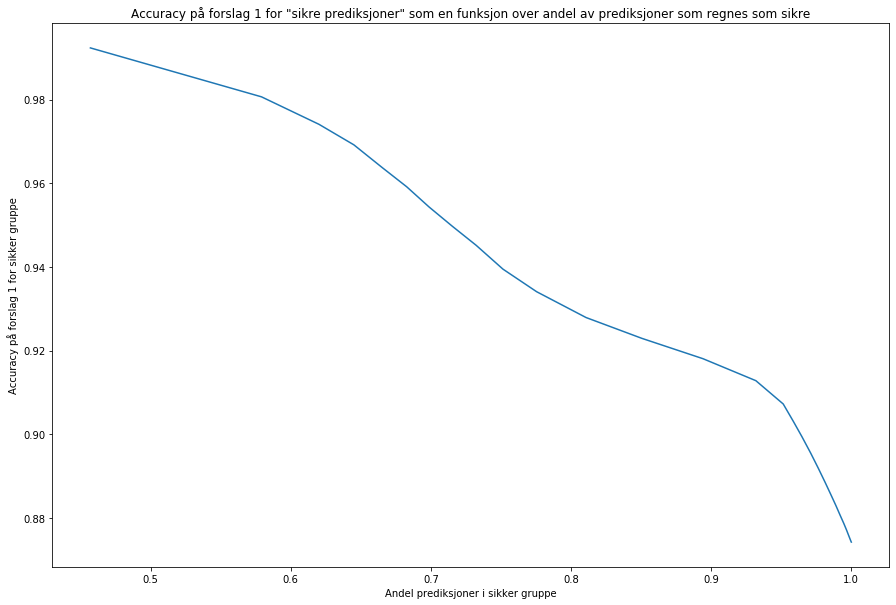

In [52]:
plt.figure(figsize=(15,10))
plt.title('Accuracy på forslag 1 for "sikre prediksjoner" som en funksjon over andel av prediksjoner som regnes som sikre')
plt.xlabel('Andel prediksjoner i sikker gruppe')
plt.ylabel('Accuracy på forslag 1 for sikker gruppe')
plt.plot(x, y)
plt.savefig('pred1_auto.png')

## Store results for analysis

In [53]:
result_df = X_test.loc[:, ['ProductName', 'CatalogueID']]

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [54]:
result_df['Label'] = y_test_raw

In [55]:
result_df.head()

,ProductName,CatalogueID,Label
3252119,"God yrkesutøvelse : smartbok : lærer : helsearbeiderfag vg2, vg3 Bokmål Digitalt læremiddel",NaN,551115
2018806,Tallerken flat Fasett 26802 Ø230mm Hvit Porselen,NaN,481019
3845846,Raxxess RWM-13-18 - Reléstativ - svart rynkepulverbelegg - 13U,NaN,241020
3668249,formline superdekk 250 ml. Grønn.,NaN,601212
1123921,GRX3-E3 236HF 3-4/5-6 LL,NaN,391115


In [56]:
result_df['Predicted'] = list(map(lambda x: label_cols[x], y_pred_idxs))

In [57]:
train_label_counts = y_train_raw.value_counts().to_dict()
result_df['Label count train'] = result_df['Label'].map(train_label_counts)

In [58]:
result_df['Label count test'] = result_df['Label'].map(label_counts)

In [59]:
result_df['PredLabel count train'] = result_df['Predicted'].map(train_label_counts)

In [60]:
result_df['PredLabel count test'] = result_df['Predicted'].map(label_counts)

In [61]:
result_df.fillna(0, inplace=True)

In [62]:
if SCENARIO2:
    result_df['CatalogSize'] = result_df['CatalogueID'].map(catalog_counts)

In [63]:
result_df.to_pickle('scen2_lstm_results.pkl')

In [64]:
result_df.sample(10)

,ProductName,CatalogueID,Label,Predicted,Label count train,Label count test,PredLabel count train,PredLabel count test
1233932,"REKKEKL FJÆR 1,5-10 BLÅ",0.0,391214,391214,14344.0,1831,14344,1831.0
1316642,RIBBERØRSOVN 125-42B 775W,0.0,401018,401018,2530.0,329,2530,329.0
3471313,Småromskap Manutan Uni 400 2x2 rom sokkel grått,0.0,561015,561015,7228.0,930,7228,930.0
1614278,"3925E UC Bundle w/ PVDM3-64,FL-CME-SRST-25, UC Lic,FL-CUBE25",0.0,432226,432226,3522.0,429,3522,429.0
3921090,"STYREPULT B,H,D=1000, 1400, 4",0.0,391213,391213,20217.0,2643,20217,2643.0
3349009,Jadearmbåndet Bokmål Heftet,0.0,551115,551015,50766.0,6470,90960,11232.0
4041238,TORK STANDARD 130109 INDUSTRIRULL W1,0.0,471321,471321,112.0,8,112,8.0
3543780,"Plastkasse/skuff 15,7cm høy koksgrå",0.0,561216,561216,5029.0,642,5029,642.0
2357272,Donalds verdenshistorie 3 : middelalderen Bokmål Innbundet,0.0,551015,551015,90960.0,11232,90960,11232.0
3854995,MicroConnect - Video adapter - HDMI / DVI - 19-pin HDMI (hunn) - DVI-D (hann),0.0,261216,261216,17142.0,2219,17142,2219.0


In [65]:
if SCENARIO2:
    pickle.dump(dict(score_dict), open('lstm_catalog_scores.pkl', 'wb'))
pickle.dump(dict(label_score_dict), open('lstm_label_scores.pkl', 'wb'))
pickle.dump(dict(product_label_map), open('lstm_product_label_map.pkl', 'wb'))

In [66]:
if SCENARIO2:
    plt.hist(list(score_dict.values()), bins=100)


# Top K scores

In [67]:
TOP_K = 5

## Gather top K predictions for each test case

In [68]:
y_true_idxs = y_test.values.argmax(axis=1)
y_pred_idxs = np.argpartition(preds, axis=1, kth=-TOP_K)[:,-TOP_K:]

In [69]:
df_y_test = pd.DataFrame(y_true_idxs)
df_y_test = df_y_test.iloc[:,0].apply(lambda x: label_cols[x])
df_y_test.head()

0    551115
1    481019
2    241020
3    601212
4    391115
Name: 0, dtype: object

In [70]:
y_pred_idxs.shape, y_true_idxs.shape

((86517, 5), (86517,))

In [71]:
def top_k_score(k, scores):
    for i in range(k+1):
        if scores[i] > 0:
            return scores[i]
    return 0

## Micro scores

In [72]:
y_pred_idxs.shape, y_test.shape

((86517, 5), (86517, 1028))

In [73]:
score = [0]*TOP_K
score_h = [0]*TOP_K
score_any = [0]*TOP_K
score_any_h = [0]*TOP_K
for i, idmaxes in enumerate(y_pred_idxs):
    top_k_preds = preds[i, idmaxes]
    sorted_order = np.argsort(top_k_preds)[::-1] #descending sort
    sorted_idmaxes = idmaxes[sorted_order]
    sorted_preds = top_k_preds[sorted_order]
    scores = []
    scores_h = []
    scores_any = []
    scores_any_h = []
    for j, idmax in enumerate(sorted_idmaxes):
        scores.append(acc(label_cols[y_true_idxs[i]], label_cols[idmax]))
        scores_h.append(h_acc(label_cols[y_true_idxs[i]], label_cols[idmax]))
        if BUSINESS_CODE:
            scores_any.append(any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax]))
            scores_any_h.append(any_hacc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax]))
        else:
            scores_any.append(any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax]))
            scores_any_h.append(any_hacc(product_label_map[X_test.iloc[i]], label_cols[idmax]))
    for j in range(TOP_K):       
        score[j] += top_k_score(j, scores)
        score_h[j] += top_k_score(j, scores_h)
        score_any[j] += top_k_score(j, scores_any)
        score_any_h[j] += top_k_score(j, scores_any_h)
for i in range(TOP_K):
    score[i] /= y_test.shape[0]
    score_h[i] /= y_test.shape[0]
    score_any[i] /= y_test.shape[0]
    score_any_h[i] /= y_test.shape[0]

In [74]:
score, score_h, score_any, score_any_h

([0.8169608285076921,
  0.9306725845787533,
  0.9433521735612654,
  0.9504143694302853,
  0.9555231919738317],
 [0.866870672815928,
  0.889729995261242,
  0.8960814637587688,
  0.8991921818835339,
  0.9014127859266725],
 [0.8742096928927263,
  0.9336777743102511,
  0.945767883768508,
  0.9525526775084665,
  0.9574303316111284],
 [0.9054181259175592,
  0.9272310644152085,
  0.9334251072044933,
  0.9364702890762674,
  0.9386333321776256])

In [75]:
#use seaborn plots
sns.set()

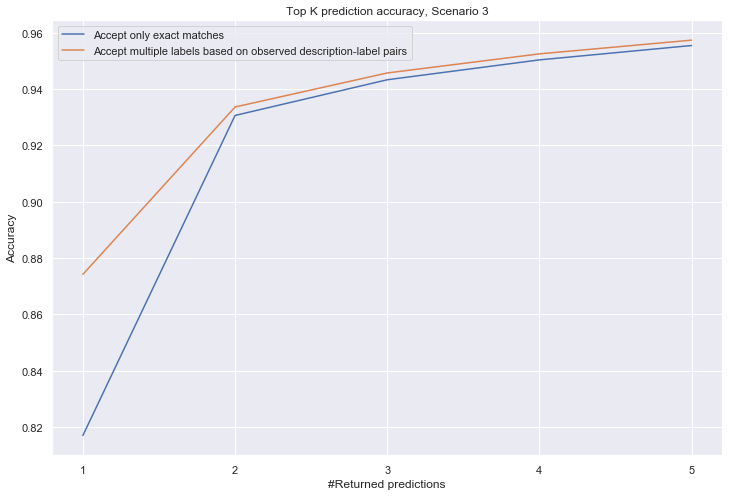

In [76]:
x = list(range(1,6))
plt.figure(figsize=(12,8))
plt.plot(x, score, label='Accept only exact matches')
plt.plot(x, score_any, label='Accept multiple labels based on observed description-label pairs')
plt.xticks(list(range(1,6)))
plt.xlabel('#Returned predictions')
plt.ylabel('Accuracy')
plt.title('Top K prediction accuracy, Scenario 3')

plt.legend()
#plt.savefig('topkacc.png')

## Class macro scores and statistics

In [77]:
label_counts = y_test_raw.value_counts()
label_score_dict = {}
score = 0
for i, idmaxes in enumerate(y_pred_idxs):
    label = y_test_raw.iloc[i]
    top_k_preds = preds[i, idmaxes]
    sorted_order = np.argsort(top_k_preds)[::-1] #descending sort
    sorted_idmaxes = idmaxes[sorted_order]
    sorted_preds = top_k_preds[sorted_order]
    scores = []
    for j, idmax in enumerate(sorted_idmaxes):
        scores.append(any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax]))
    for j in range(TOP_K):
        scores[j] = top_k_score(j, scores)
    if label in label_score_dict:
        for j, s in enumerate(scores):
            label_score_dict[label][j] += s
    else:
        label_score_dict[label] = scores
for label in label_score_dict.keys():
    for i in range(TOP_K):
        label_score_dict[label][i] = label_score_dict[label][i]/label_counts[label]

In [78]:
np_scores = np.array(list(label_score_dict.values()))

In [79]:
np.average(np_scores, axis=0)

array([0.6930505 , 0.75209559, 0.77827566, 0.79122225, 0.80390306])

In [80]:
np.median(np_scores, axis=0)

array([0.77777778, 0.85714286, 0.88888889, 0.90545455, 0.91666667])

In [81]:
np.std(np_scores, axis=0)

array([0.30403458, 0.29513251, 0.28936045, 0.28578564, 0.27895367])

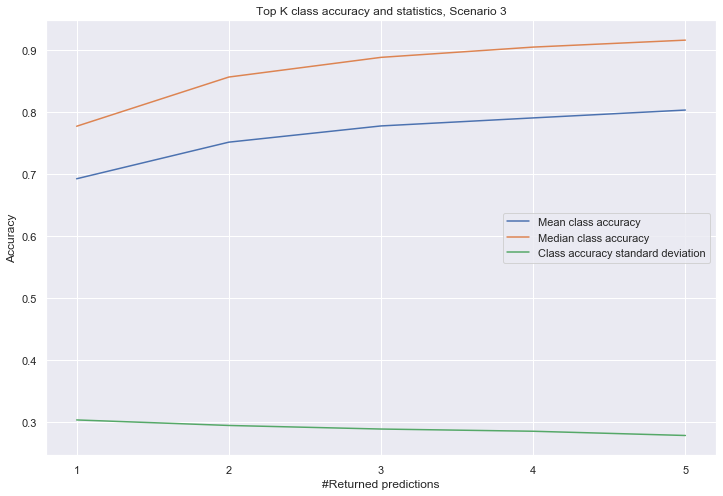

In [82]:
x = list(range(1,6))
plt.figure(figsize=(12,8))
plt.plot(x, np.average(np_scores, axis=0), label='Mean class accuracy')
plt.plot(x, np.median(np_scores, axis=0), label='Median class accuracy')
plt.plot(x, np.std(np_scores, axis=0), label='Class accuracy standard deviation')
plt.xticks(list(range(1,6)))
plt.xlabel('#Returned predictions')
plt.ylabel('Accuracy')
plt.title('Top K class accuracy and statistics, Scenario 3')

plt.legend()
#plt.savefig('topkclasses.png')

## Catalog macro scores and statistics

In [83]:
if SCENARIO2:
    catalog_counts = X_test['CatalogueID'].value_counts().to_dict()
    score_dict = {}
    score = 0
    for i, idmaxes in enumerate(y_pred_idxs):
        catalog_name = X_test['CatalogueID'].iloc[i]
        label = y_test_raw.iloc[i]
        top_k_preds = preds[i, idmaxes]
        sorted_order = np.argsort(top_k_preds)[::-1] #descending sort
        sorted_idmaxes = idmaxes[sorted_order]
        sorted_preds = top_k_preds[sorted_order]
        scores = []
        for j, idmax in enumerate(sorted_idmaxes):
            scores.append(any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax]))
        for j in range(TOP_K):
            scores[j] = top_k_score(j, scores)
        if catalog_name in score_dict:
            for j, s in enumerate(scores):
                score_dict[catalog_name][j] += s
        else:
            score_dict[catalog_name] = scores
        
    for catalog_name in score_dict.keys():
        for i in range(TOP_K):
            score_dict[catalog_name][i] = score_dict[catalog_name][i]/catalog_counts[catalog_name]

In [84]:
if SCENARIO2:
    np_scores = np.array(list(score_dict.values()))
    np.average(np_scores, axis=0), np.median(np_scores, axis=0), np.std(np_scores, axis=0)

In [85]:
if SCENARIO2:
    x = list(range(1,6))
    plt.figure(figsize=(12,8))
    plt.plot(x, np.average(np_scores, axis=0), label='Mean class accuracy')
    plt.plot(x, np.median(np_scores, axis=0), label='Median class accuracy')
    plt.xticks(list(range(1,6)))
    plt.xlabel('#Returned predictions')
    plt.ylabel('Accuracy')
    plt.title('Top K class accuracy and statistics, Scenario 3')

    plt.legend()
    #plt.savefig('topkkatalogs.png')